### Importations

In [99]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import datetime
from datetime import datetime
!pip install ruptures
import ruptures as rpt
import yfinance as yf

In [100]:
df = pd.read_excel("camaroes_brasil.xlsx")
df.head()

,Ano,Mês,UF do Produto,Via,Bloco Econômico,Código NCM,Descrição NCM,Países,Valor US$ FOB,Quilograma Líquido
0,2025,02. Fevereiro,Pará,MARITIMA,Ásia (Exclusive Oriente Médio),3061790,"Outros camarões, que não inteiros, congelados",Japão,256538,16916
1,2025,02. Fevereiro,Rio de Janeiro,AEREA,América do Norte,3061710,"Outros camarões inteiros, congelados",Canadá,12114,232
2,2025,02. Fevereiro,São Paulo,MARITIMA,África,3061710,"Outros camarões inteiros, congelados",Libéria,4788,355
3,2025,01. Janeiro,São Paulo,MARITIMA,África,3061710,"Outros camarões inteiros, congelados",Libéria,2990,259
4,2025,01. Janeiro,São Paulo,MARITIMA,Ásia (Exclusive Oriente Médio),3061790,"Outros camarões, que não inteiros, congelados",Singapura,2126,145


### New variables

In [101]:
df['Tons'] = df['Quilograma Líquido']/1000
df['Price/Kg'] = df['Valor US$ FOB']/df['Quilograma Líquido']
df['Mês'] = df['Mês'].str.extract(r'(\d{2})')
df['Date'] = df['Ano'].map(str) + '/' + df['Mês'].map(str)

### Exploratory analysis

#### Value counts

In [102]:
df["Bloco Econômico"].value_counts()

,count
Bloco Econômico,
Europa,5170
Ásia (Exclusive Oriente Médio),2343
América Central e Caribe,1747
África,927
América do Norte,842
América do Sul,177
Oriente Médio,121


In [103]:
df_gp2 = df.groupby(["Bloco Econômico"])["Tons"].sum()
df_gp2
# Europa, América do Norte e Ásia maiores compradores do camarão brasileiro no geral

,Tons
Bloco Econômico,
América Central e Caribe,934.055
América do Norte,68849.890
América do Sul,1009.973
Europa,227267.829
Oriente Médio,136.464
África,119.454
Ásia (Exclusive Oriente Médio),17602.652


In [104]:
df["Descrição NCM"].value_counts()

,count
Descrição NCM,
"Outros camarões, que não inteiros, congelados",3451
"Outros camarões inteiros, congelados",2999
"Camarões, inteiros, congelados, exceto ""krill""",1761
"Outros camarões congelados, exceto ""krill""",1252
Camarões,1014
Camarões congelados,850


In [105]:
df["UF do Produto"].value_counts()

,count
UF do Produto,
São Paulo,2241
Maranhão,934
Ceará,894
Bahia,855
Pará,845
Santa Catarina,773
Espírito Santo,772
Rio Grande do Norte,743
Rio de Janeiro,695


#### Time series

In [106]:
df_grouped = df.groupby(["Ano"])["Tons"].sum().reset_index()
df_grouped.set_index('Ano', inplace=True)
serie_full = df_grouped["Tons"].values

In [107]:
model = rpt.Pelt(model="l2").fit(serie_full)
breakpoints = model.predict(pen=10)
anos_breakpoints = df_grouped.index[breakpoints[:-1]].to_numpy()

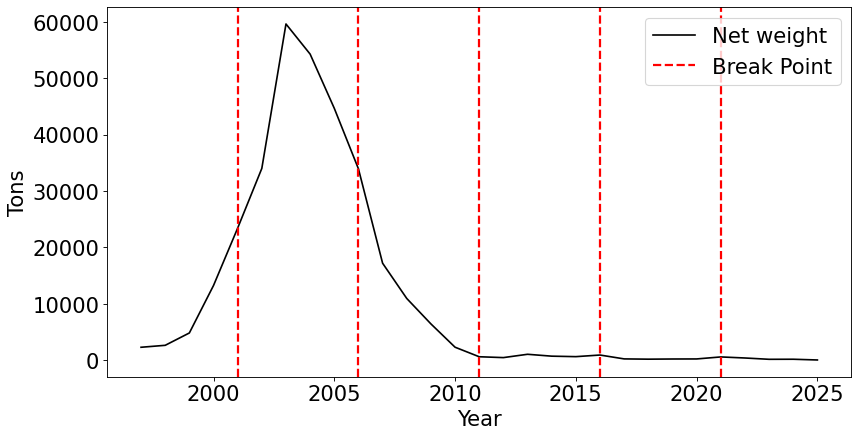

In [108]:
# Plotando os breakpoints
fig, ax = plt.subplots(figsize=(12, 6), dpi=80)
plt.rcParams.update({"font.size": 19})
plt.rcParams["xtick.labelsize"] = "19"

plt.plot(df_grouped.index, serie_full, color="black", linestyle="solid", label="Net weight")

first_break = True
for bp in breakpoints[:-1]:
    ano_quebra = df_grouped.index[bp - 1]
    if first_break:
        plt.axvline(x=ano_quebra, color="red", linestyle="dashed", linewidth=2, label="Break Point")
        first_break = False
    else:
        plt.axvline(x=ano_quebra, color="red", linestyle="dashed", linewidth=2)

plt.xlabel("Year", fontsize=19)
plt.ylabel("Tons", fontsize=19)
plt.legend()
plt.show()

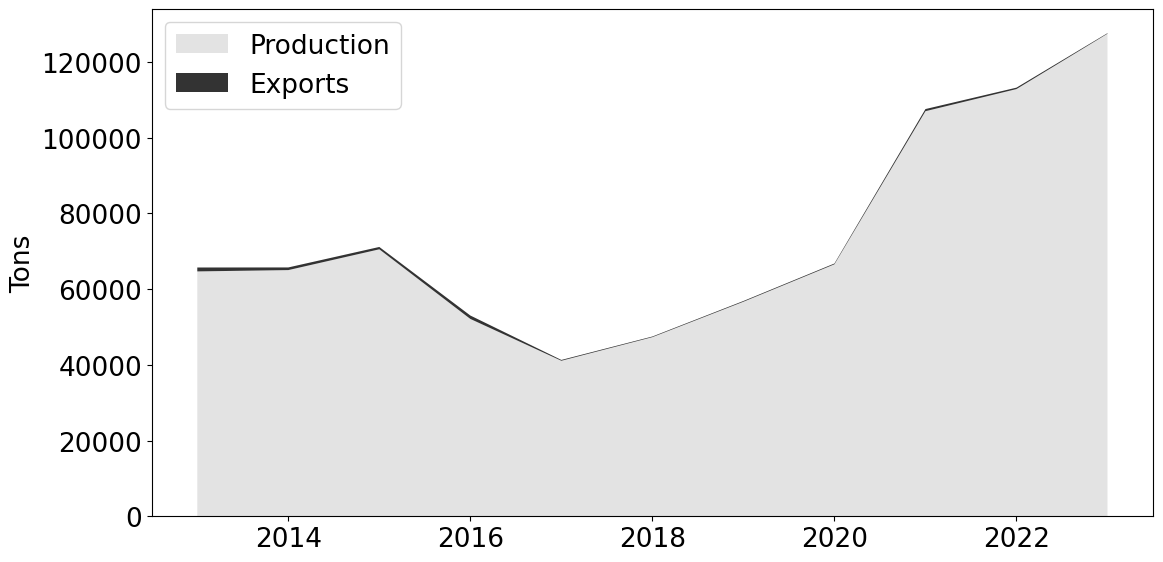

In [109]:
prod = [64678038, 65027554, 70521245, 52127207, 41078069, 47316463, 56667254, 66561265, 106996612, 112841425, 127466349]
ano = [2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]
prod = [x / 1000 for x in prod]

plt.rcParams.update({"font.size": 19})
plt.rcParams["xtick.labelsize"] = "19"

df_aux = df_grouped.reset_index()
exp = df_aux[(df_aux['Ano'] >= 2013) & (df_aux['Ano'] <= 2023)]['Tons'].values

plt.figure(figsize=(12, 6))

stack = plt.stackplot(ano, prod, exp, colors=['gainsboro', 'black'], alpha=0.8)
plt.ylabel("Tons")
plt.legend(stack, ["Production", "Exports"])
plt.tight_layout()
#plt.savefig("shrimp_prod_export_series.png", dpi=500)
plt.show()

In [110]:
ts1 = df[df['Ano'] <= 2012].groupby(["Ano"])["Tons"].sum().reindex(range(1997, 2013), fill_value=0).reset_index()
ts1.set_index('Ano', inplace=True)
serie1 = ts1["Tons"].values

ts2 = df[df['Ano'] >= 2011].groupby(["Ano"])["Tons"].sum().reindex(range(2011, 2025), fill_value=0).reset_index()
ts2.set_index('Ano', inplace=True)
serie2 = ts2["Tons"].values

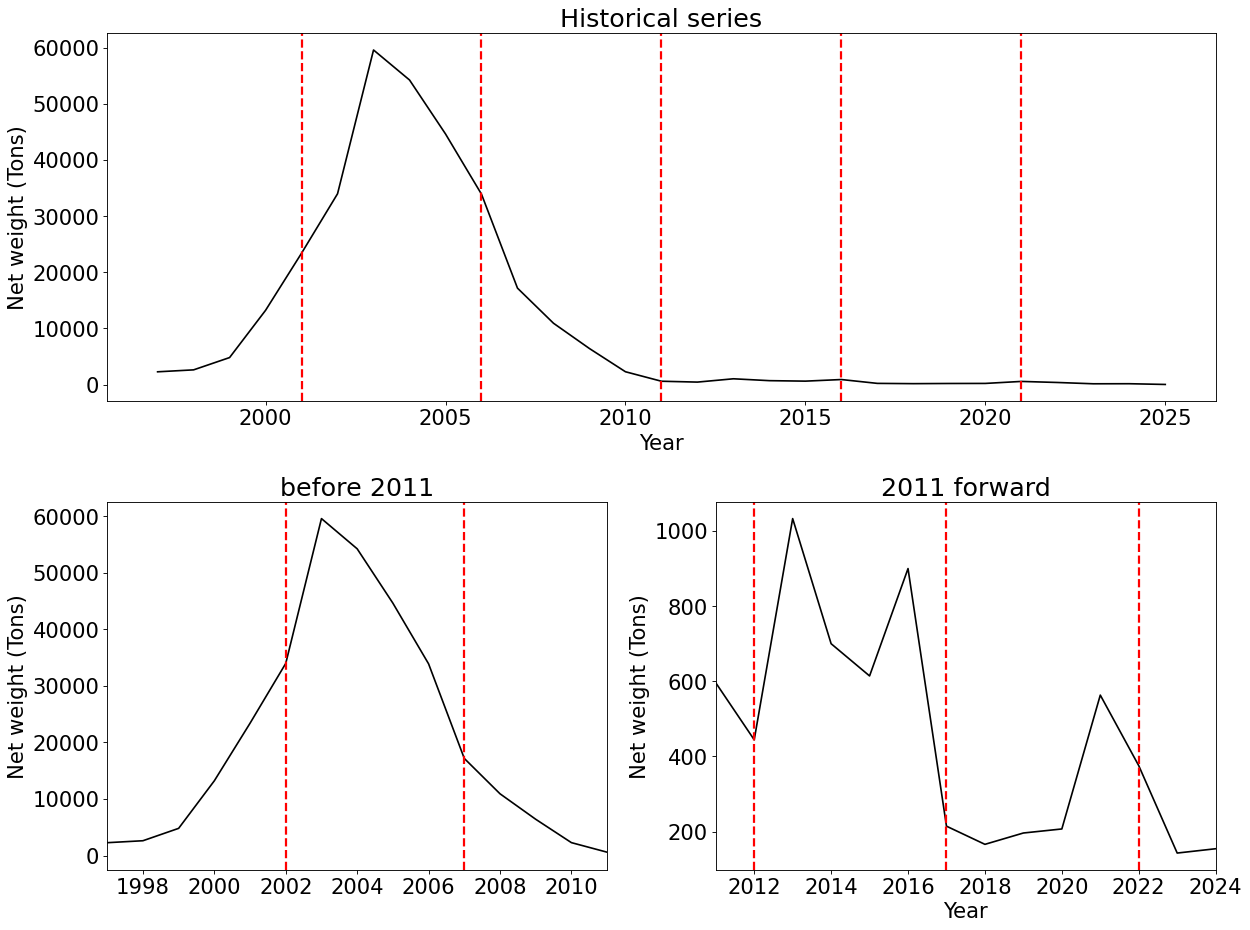

In [111]:
fig = plt.figure(figsize=(16, 12), dpi=80)
gs = gridspec.GridSpec(nrows=2, ncols=2, height_ratios=[1, 1])

ax_top = fig.add_subplot(gs[0, :])
ax_top.plot(df_grouped.index, serie_full, color="black", linestyle="solid", label="Net weight")
first_break = True

for bp in breakpoints[:-1]:
    ano_quebra = df_grouped.index[bp - 1]
    if first_break:
        ax_top.axvline(x=ano_quebra, color="red", linestyle="dashed", linewidth=2, label="Break Point")
        first_break = False
    else:
        ax_top.axvline(x=ano_quebra, color="red", linestyle="dashed", linewidth=2)

ax_top.set_xlabel("Year", fontsize=19)
ax_top.set_ylabel("Net weight (Tons)", fontsize=19)
ax_top.set_title("Historical series")

ax_left = fig.add_subplot(gs[1, 0])
ax_left.plot(ts1.index, serie1, color="black", linestyle="solid", label="Net weight")

for bp in breakpoints[:-1]:
    ano_quebra = df_grouped.index[bp]
    if 1997 <= ano_quebra <= 2011:
        if 'Break Point' not in ax_left.get_legend_handles_labels()[1]:
            ax_left.axvline(x=ano_quebra, color="red", linestyle="dashed", linewidth=2, label="Break Point")
        else:
            ax_left.axvline(x=ano_quebra, color="red", linestyle="dashed", linewidth=2)

ax_left.set_xlim([1997, 2011])
ax_left.set_ylabel("Net weight (Tons)", fontsize=19)
ax_left.set_title("before 2011")

ax_right = fig.add_subplot(gs[1, 1])
ax_right.plot(ts2.index, serie2, color="black", linestyle="solid", label="Net weight")

for bp in breakpoints[:-1]:
    ano_quebra = df_grouped.index[bp]
    if 2011 <= ano_quebra <= 2024:
        if 'Break Point' not in ax_right.get_legend_handles_labels()[1]:
            ax_right.axvline(x=ano_quebra, color="red", linestyle="dashed", linewidth=2, label="Break Point")
        else:
            ax_right.axvline(x=ano_quebra, color="red", linestyle="dashed", linewidth=2)

ax_right.set_xlim([2011, 2024])
ax_right.set_xlabel("Year", fontsize=19)
ax_right.set_ylabel("Net weight (Tons)", fontsize=19)
ax_right.set_title("2011 forward")

plt.tight_layout()
#plt.savefig("shrimp_export_series.jpeg", dpi=400)
plt.show()

In [112]:
serie_full = df_grouped["Tons"]  # série completa
ts_full = df_grouped.index       # index com os anos

# Separando as séries
ts11 = df_grouped.loc[df_grouped.index <= 2011]  # antes de 2011
serie11 = ts11["Tons"]

ts21 = df_grouped.loc[df_grouped.index > 2011]   # depois de 2011
serie21 = ts21["Tons"]

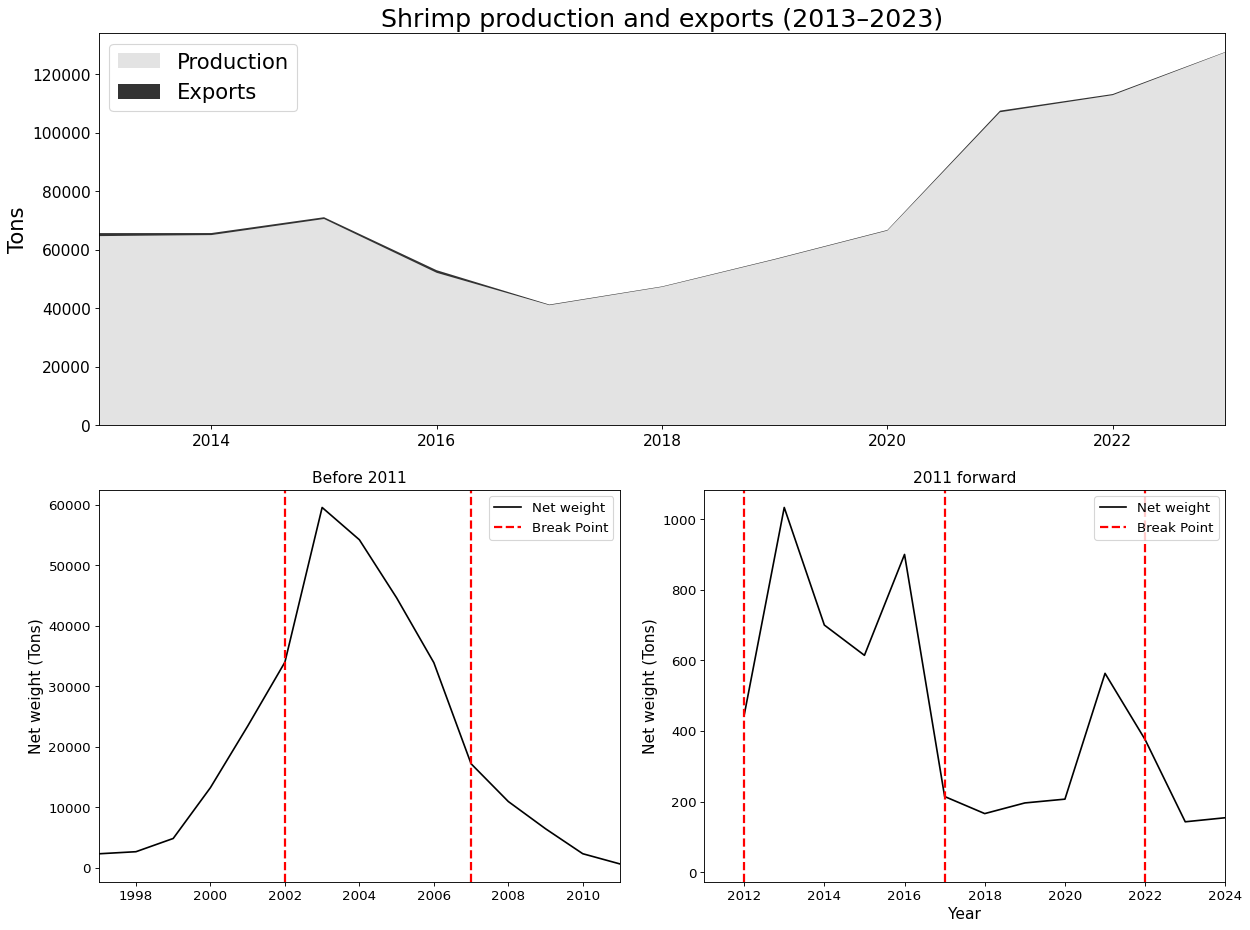

In [113]:
# --- Início do gráfico unificado ---
fig = plt.figure(figsize=(16, 12), dpi=80)
gs = gridspec.GridSpec(nrows=2, ncols=2, height_ratios=[1, 1])

# --- Parte superior: stackplot ---
ax_top = fig.add_subplot(gs[0, :])  # ocupa as duas colunas da primeira linha
stack = ax_top.stackplot(ano, prod, exp, colors=['gainsboro', 'black'], alpha=0.8)
ax_top.set_ylabel("Tons")
ax_top.set_title("Shrimp production and exports (2013–2023)")
ax_top.legend(stack, ["Production", "Exports"])
ax_top.tick_params(axis='both', labelsize=14)
ax_top.set_xlim([2013, 2023])

# --- Parte inferior esquerda: before 2011 ---
ax_left = fig.add_subplot(gs[1, 0])
ax_left.plot(ts11.index, serie11, color="black", linestyle="solid", label="Net weight")

for bp in breakpoints[:-1]:
    ano_quebra = df_grouped.index[bp]
    if 1997 <= ano_quebra <= 2011:
        if 'Break Point' not in ax_left.get_legend_handles_labels()[1]:
            ax_left.axvline(x=ano_quebra, color="red", linestyle="dashed", linewidth=2, label="Break Point")
        else:
            ax_left.axvline(x=ano_quebra, color="red", linestyle="dashed", linewidth=2)

ax_left.set_xlim([1997, 2011])
ax_left.set_ylabel("Net weight (Tons)", fontsize=14)
ax_left.set_title("Before 2011", fontsize=14)
ax_left.legend(fontsize=12)
ax_left.tick_params(axis='both', labelsize=12)

# --- Parte inferior direita: after 2011 ---
ax_right = fig.add_subplot(gs[1, 1])
ax_right.plot(ts21.index, serie21, color="black", linestyle="solid", label="Net weight")

for bp in breakpoints[:-1]:
    ano_quebra = df_grouped.index[bp]
    if 2011 <= ano_quebra <= 2024:
        if 'Break Point' not in ax_right.get_legend_handles_labels()[1]:
            ax_right.axvline(x=ano_quebra, color="red", linestyle="dashed", linewidth=2, label="Break Point")
        else:
            ax_right.axvline(x=ano_quebra, color="red", linestyle="dashed", linewidth=2)

ax_right.set_xlim([2011, 2024])
ax_right.set_xlabel("Year", fontsize=14)
ax_right.set_ylabel("Net weight (Tons)", fontsize=14)
ax_right.set_title("2011 forward", fontsize=14)
ax_right.legend(fontsize=12)
ax_right.tick_params(axis='both', labelsize=12)

# --- Layout final ---
plt.tight_layout()
# plt.savefig("combined_shrimp_graph.jpeg", dpi=400)
plt.show()

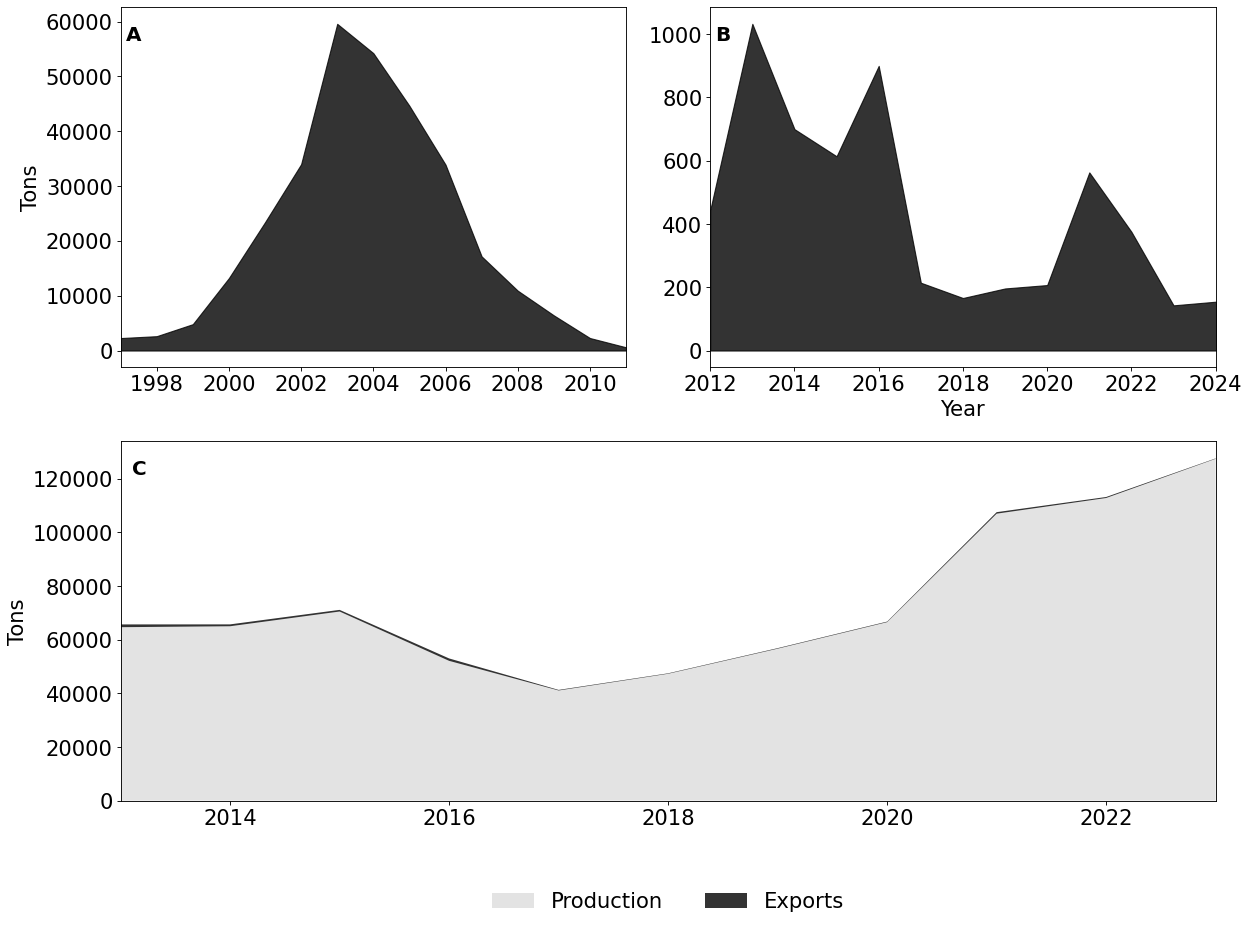

In [114]:
# --- Início do gráfico unificado (inversão de posição) ---
fig = plt.figure(figsize=(16, 12), dpi=80)
gs = gridspec.GridSpec(nrows=2, ncols=2, height_ratios=[1, 1])

# --- Parte superior esquerda: before 2011 ---
ax_left = fig.add_subplot(gs[0, 0])
ax_left.fill_between(ts11.index, serie11, color="black",alpha=0.8)

ax_left.set_xlim([1997, 2011])
ax_left.set_ylabel("Tons", fontsize=19)
ax_left.tick_params(axis='both', labelsize=19)
ax_left.text(0.01, 0.95, 'A', transform=ax_left.transAxes, fontsize=18, fontweight='bold', va='top')

# --- Parte superior direita: after 2011 ---
ax_right = fig.add_subplot(gs[0, 1])
ax_right.fill_between(ts21.index, serie21, color="black", alpha=0.8)

ax_right.set_xlim([2012, 2024])
ax_right.set_xlabel("Year", fontsize=19)
ax_right.tick_params(axis='both', labelsize=19)
ax_right.text(0.01, 0.95, 'B', transform=ax_right.transAxes, fontsize=18, fontweight='bold', va='top')

# --- Parte inferior: stackplot ---
ax_bottom = fig.add_subplot(gs[1, :])  # ocupa as duas colunas da segunda linha
stack = ax_bottom.stackplot(ano, prod, exp, colors=['gainsboro', 'black'], alpha=0.8)
ax_bottom.set_ylabel("Tons")
ax_bottom.legend(stack, ["Production", "Exports"],
                 loc='upper center',
                 bbox_to_anchor=(0.5, -0.2),
                 fontsize=19,
                 ncol=2,
                 frameon=False)
ax_bottom.tick_params(axis='both', labelsize=19)
ax_bottom.set_xlim([2013, 2023])
ax_bottom.text(0.01, 0.95, 'C', transform=ax_bottom.transAxes, fontsize=18, fontweight='bold', va='top')

# --- Layout final ---
plt.tight_layout()
plt.subplots_adjust(bottom=0.15)
plt.savefig("combined_shrimp_graph_inverted.png", dpi=500)
plt.show()

#### blocos economicos

In [115]:
df_grouped = df.groupby(['Ano', 'Bloco Econômico'])['Tons'].sum().unstack().fillna(0)


df_before_2011 = df_grouped[df_grouped.index < 2011]
df_after_2011 = df_grouped[df_grouped.index >= 2011]

In [116]:
anos_before = df_before_2011.index
blocos_before = df_before_2011.columns
valores_before = df_before_2011.values.T

anos_after = df_after_2011.index
blocos_after = df_after_2011.columns
valores_after = df_after_2011.values.T

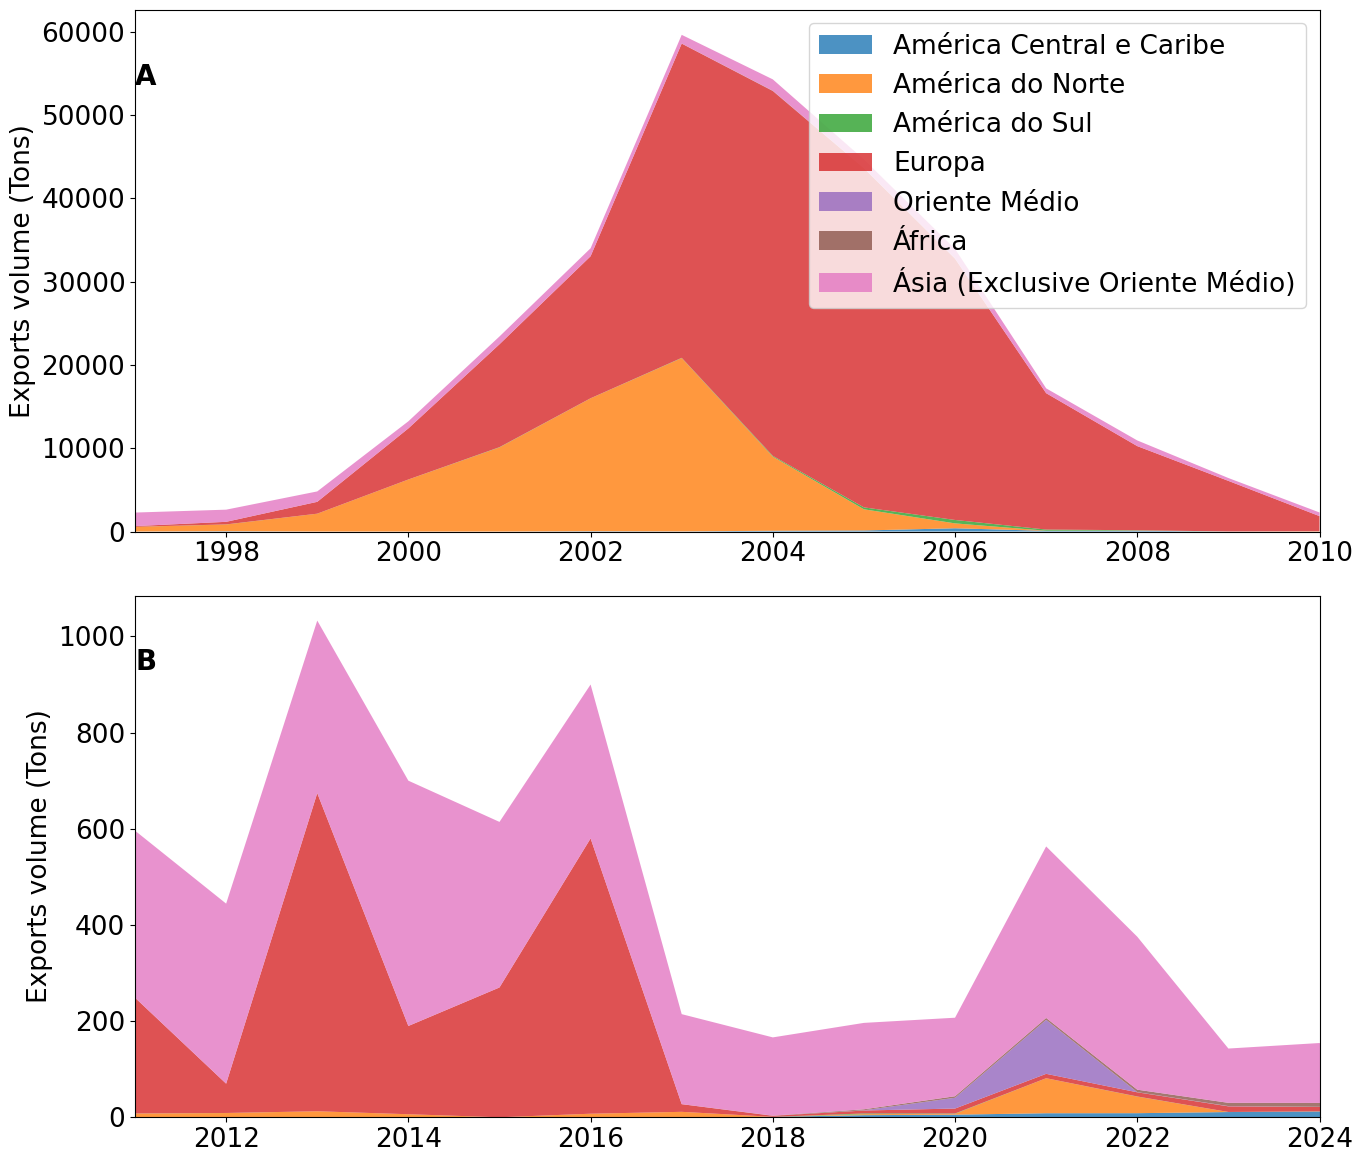

In [117]:
fig, axes = plt.subplots(2, 1, figsize=(14, 12), sharex=False)

# Stackplot antes de 2011
axes[0].stackplot(anos_before, valores_before, labels=blocos_before, alpha=0.8)
axes[0].set_ylabel("Exports volume (Tons)", fontsize=19)
axes[0].legend(loc='upper right')
axes[0].set_xlim(1997, 2010)
axes[0].text(anos_before[0], max(valores_before.sum(axis=0)) * 0.9, 'A', fontsize=20, fontweight='bold')

# Stackplot após 2011
axes[1].stackplot(anos_after, valores_after, labels=blocos_after, alpha=0.8)
axes[1].set_ylabel("Exports volume (Tons)", fontsize=19)
axes[1].set_xlim(2011, 2024)
axes[1].text(anos_after[0], max(valores_after.sum(axis=0)) * 0.9, 'B', fontsize=20, fontweight='bold')

plt.tight_layout()

# Salvar a figura
#plt.savefig("shrimp_Exports_stackplot_split.jpeg", dpi=400, bbox_inches='tight')
plt.show()

In [118]:
def categorize_region(region):
    if region in ["NAFTA", "América do Norte"]:
        return "North America"
    elif region in ["Ásia", "Sudeste Asiático", "Leste Asiático", "Ásia (Exclusive Oriente Médio)"]:
        return "Asia"
    elif region in ["União Europeia", "Europa"]:
        return "Europe"
    else:
        return "Others"

In [119]:
df['Região Simplificada'] = df['Bloco Econômico'].apply(categorize_region)
df_grouped = df.groupby(['Ano', 'Região Simplificada'])['Tons'].sum().unstack().fillna(0)


In [120]:
df_before_2011 = df_grouped[df_grouped.index < 2011]
df_after_2011 = df_grouped[df_grouped.index >= 2011]

anos_before = df_before_2011.index
blocos_before = df_before_2011.columns
valores_before = df_before_2011.values.T

anos_after = df_after_2011.index
blocos_after = df_after_2011.columns
valores_after = df_after_2011.values.T

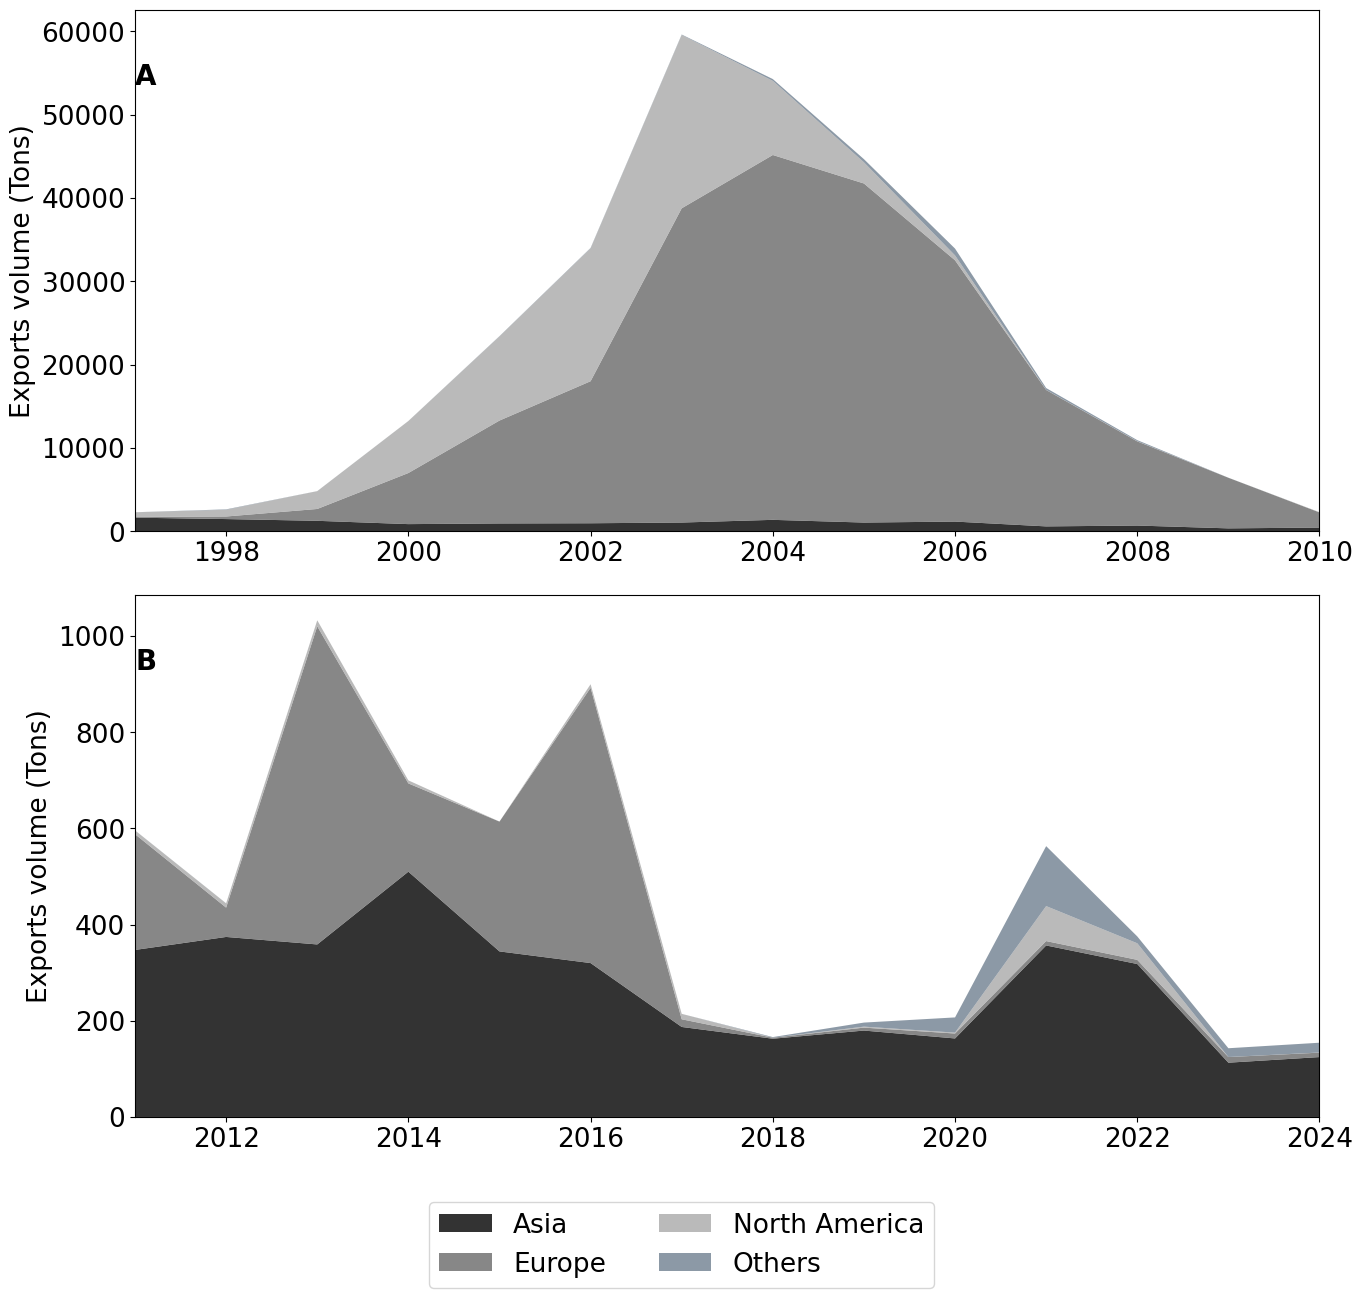

In [121]:
colors = ["black", "dimgrey", "darkgrey", "slategrey"]


fig, axes = plt.subplots(2, 1, figsize=(14, 12), sharex=False)

# Stackplot antes de 2011
axes[0].stackplot(anos_before, valores_before, labels=blocos_before, alpha=0.8, colors=colors)
axes[0].set_ylabel("Exports volume (Tons)", fontsize=19)
axes[0].set_xlim(1997, 2010)
axes[0].text(anos_before[0], max(valores_before.sum(axis=0)) * 0.9, 'A', fontsize=20, fontweight='bold')

# Stackplot após 2011
axes[1].stackplot(anos_after, valores_after, labels=blocos_after, alpha=0.8, colors=colors)
axes[1].set_ylabel("Exports volume (Tons)", fontsize=19)
axes[1].set_xlim(2011, 2024)
axes[1].text(anos_after[0], max(valores_after.sum(axis=0)) * 0.9, 'B', fontsize=20, fontweight='bold')

handles, labels = axes[1].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.1), ncol=2)

plt.tight_layout()
plt.tight_layout()

# Salvar a figura
#plt.savefig("shrimp_import_stackplot_split.jpeg", dpi=400, bbox_inches='tight')
plt.show()

#### Estados exportadores

In [122]:
def categorize_state(estado):
    if estado in ["Rio Grande do Sul", "Santa Catarina", "Paraná"]:
        return "South"
    elif estado in ["Pernambuco", "Alagoas", "Rio Grande do Norte", "Ceará",
                   "Sergipe", "Bahia", "Paraíba", "Maranhão", "Piauí"]:
        return "Northeast"
    elif estado in ["Acre", "Amazonas", "Pará", "Amapá", "Rondônia"]:
        return "North"
    elif estado in ["Rio de Janeiro", "Espírito Santo", "São Paulo"]:
        return "Southeast"
    else:
        return "Others"

In [123]:
df['Mesoregião'] = df['UF do Produto'].apply(categorize_state)
df_grouped = df.groupby(['Ano', 'Mesoregião'])['Tons'].sum().unstack().fillna(0)

In [124]:
df_before_2011 = df_grouped[df_grouped.index < 2011]
df_after_2011 = df_grouped[df_grouped.index >= 2011]

anos_before = df_before_2011.index
blocos_before = df_before_2011.columns
valores_before = df_before_2011.values.T

anos_after = df_after_2011.index
blocos_after = df_after_2011.columns
valores_after = df_after_2011.values.T

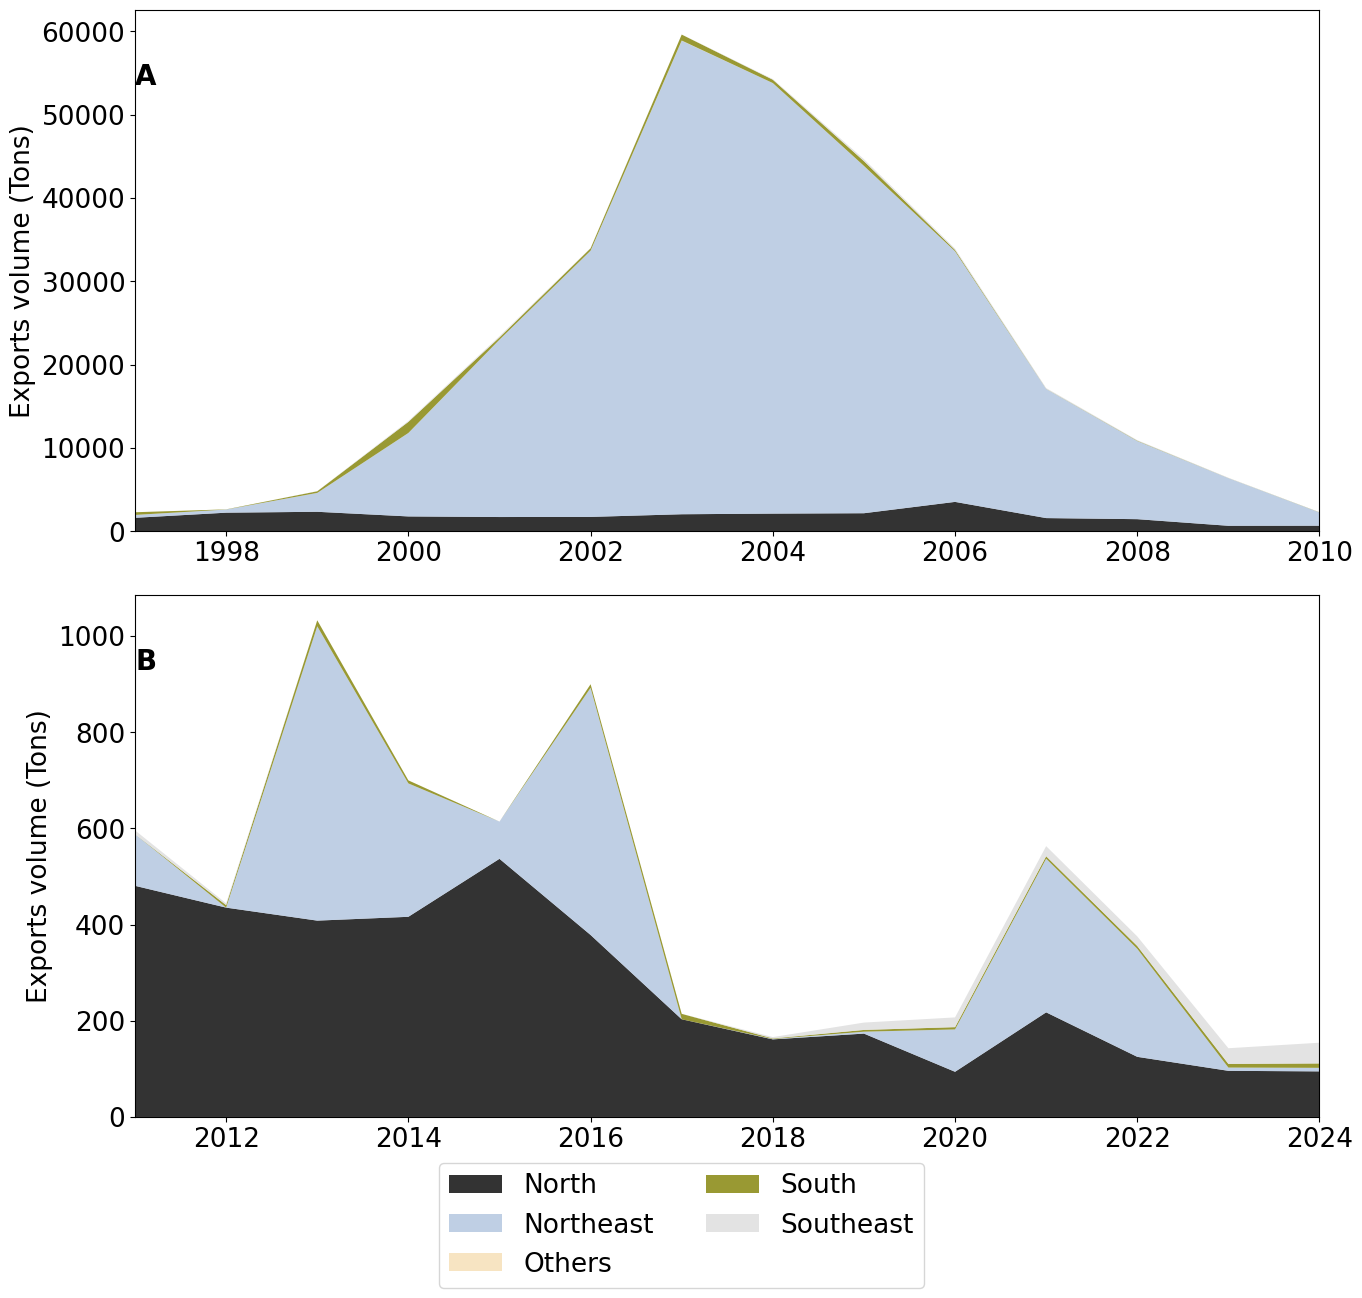

In [125]:
colors = ["black", "lightsteelblue", "wheat", "olive", "gainsboro"]


fig, axes = plt.subplots(2, 1, figsize=(14, 12), sharex=False)

# Stackplot antes de 2011
axes[0].stackplot(anos_before, valores_before, labels=blocos_before, alpha=0.8, colors=colors)
axes[0].set_ylabel("Exports volume (Tons)", fontsize=19)
axes[0].set_xlim(1997, 2010)
axes[0].text(anos_before[0], max(valores_before.sum(axis=0)) * 0.9, 'A', fontsize=20, fontweight='bold')

# Stackplot após 2011
axes[1].stackplot(anos_after, valores_after, labels=blocos_after, alpha=0.8, colors=colors)
axes[1].set_ylabel("Exports volume (Tons)", fontsize=19)
axes[1].set_xlim(2011, 2024)
axes[1].text(anos_after[0], max(valores_after.sum(axis=0)) * 0.9, 'B', fontsize=20, fontweight='bold')

handles, labels = axes[1].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.1), ncol=2)

plt.tight_layout()
plt.tight_layout()

# Salvar a figura
#plt.savefig("shrimp_export_region.jpeg", dpi=400, bbox_inches='tight')
plt.show()

### Preços

#### Preços wholesale (CEAGESP)

In [126]:
dfsp = pd.read_excel("shrimp_aqui_ceagesp.xlsx")
dfsp.head()

,Date,Day,Month,Year,Weekday,Product,Size_Quality_classification,Unit_weight,Price_smaller,Price_regular,Price_bigger,AveragePrice
0,2013-08-22,22,8,2013,5,CAMARAO FERRO,GRANDE,R$/KG,15.0,16.0,17.0,16.000000
1,2013-08-22,22,8,2013,5,CAMARAO FERRO,MEDIO,R$/KG,13.5,14.2,15.0,14.233333
2,2013-08-22,22,8,2013,5,CAMARAO FERRO,PEQUENO,R$/KG,12.0,13.0,13.5,12.833333
3,2013-08-23,23,8,2013,6,CAMARAO FERRO,GRANDE,R$/KG,14.0,15.0,16.0,15.000000
4,2013-08-23,23,8,2013,6,CAMARAO FERRO,MEDIO,R$/KG,13.0,13.5,14.0,13.500000


In [127]:
dfsp["Product"].value_counts()

,count
Product,
CAMARAO FERRO,5015
CAMARÃO CATIVEIRO,927
CAMARAO MEDIO,21
CAMARÃO MÉDIO CATIVEIRO,5


In [128]:
dfsp["Size_Quality_classification"].value_counts()

,count
Size_Quality_classification,
MEDIO,1728
GRANDE,1715
PEQUENO,1572
P,311
G,310
M,306
PRIMEIRA,10
SEGUNDA,8
TERCEIRA,8


In [129]:
dfsp["Size_Quality_classification"] = dfsp["Size_Quality_classification"].replace({
    "TERCEIRA": "S",
    "PEQUENO": "S",
    "P" : "S",
    "SEGUNDA": "M",
    "MEDIO": "M",
    "PRIMEIRA": "G",
    "GRANDE": "G"
})

dfsp['Size_Quality_classification'].value_counts()

,count
Size_Quality_classification,
M,2042
G,2035
S,1891


In [130]:
dfsp["Product"] = dfsp["Product"].replace({
    "CAMARAO FERRO":
    "CAMARÃO CATIVEIRO",
    "CAMARAO MEDIO":
    "CAMARÃO CATIVEIRO",
    "CAMARÃO MÉDIO CATIVEIRO":
    "CAMARÃO CATIVEIRO"
})

dfsp['Product'].value_counts()

,count
Product,
CAMARÃO CATIVEIRO,5968


In [131]:
dfsp["Date"] = pd.to_datetime(dfsp["Date"])
dfsp["YearMonth"] = dfsp["Date"].dt.to_period("M")

df_monthly = dfsp.groupby(["YearMonth", "Size_Quality_classification"
                           ])["AveragePrice"].mean().reset_index()
df_monthly["YearMonth"] = df_monthly["YearMonth"].astype(str)
df_monthly["YearMonth"] = pd.to_datetime(df_monthly["YearMonth"])

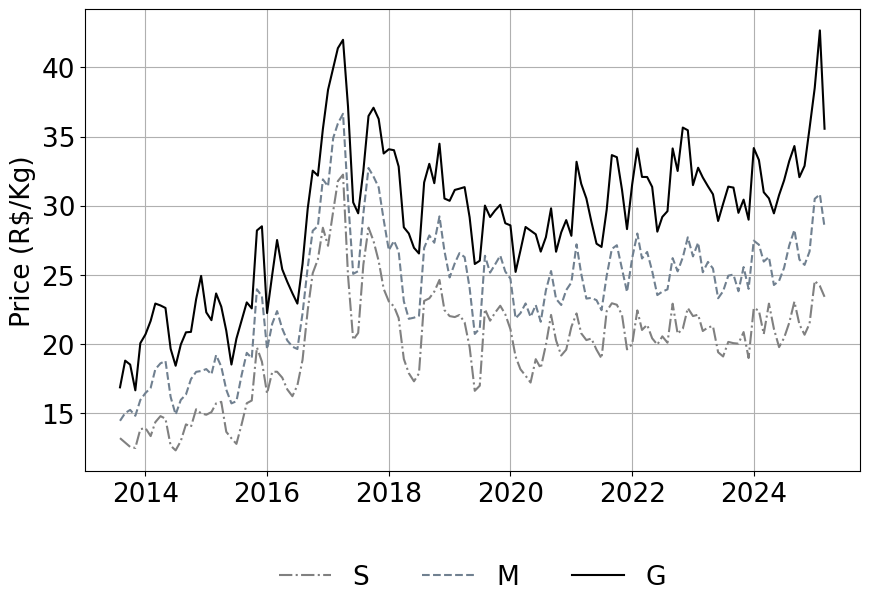

In [132]:
styles = {
    "S": {
        "color": "gray",
        "linestyle": "dashdot",
        "label": "S"
    },
    "M": {
        "color": "slategray",
        "linestyle": "dashed",
        "label": "M"
    },
    "G": {
        "color": "black",
        "linestyle": "solid",
        "label": "G"
    },
}

plt.figure(figsize=(10, 6))
for category in ["S", "M", "G"]:
    subset = df_monthly[df_monthly["Size_Quality_classification"] == category]
    plt.plot(subset["YearMonth"],
             subset["AveragePrice"],
             color=styles[category]["color"],
             linestyle=styles[category]["linestyle"],
             label=styles[category]["label"])

plt.ylabel("Price (R$/Kg)")
plt.grid(True)
plt.legend(loc="upper center",
           bbox_to_anchor=(0.5, -0.15),
           ncol=3,
           frameon=False)
#plt.savefig("shrimp_price_ceagesp.jpeg", dpi=400, bbox_inches='tight')
plt.show()

In [133]:
dfsp_monthly_avg = dfsp.groupby(
    "YearMonth")["AveragePrice"].mean().reset_index()
dfsp_monthly_avg["YearMonth"] = dfsp_monthly_avg["YearMonth"].astype(str)
dfsp_monthly_avg["YearMonth"] = pd.to_datetime(dfsp_monthly_avg["YearMonth"])

In [134]:
dfsp_monthly_avg

,YearMonth,AveragePrice
0,2013-08-01,15.124074
1,2013-09-01,15.765873
2,2013-10-01,15.830189
3,2013-11-01,14.789062
4,2013-12-01,16.630952
...,...,...
135,2024-11-01,26.434444
136,2024-12-01,27.934778
137,2025-01-01,31.201000
138,2025-02-01,32.572917


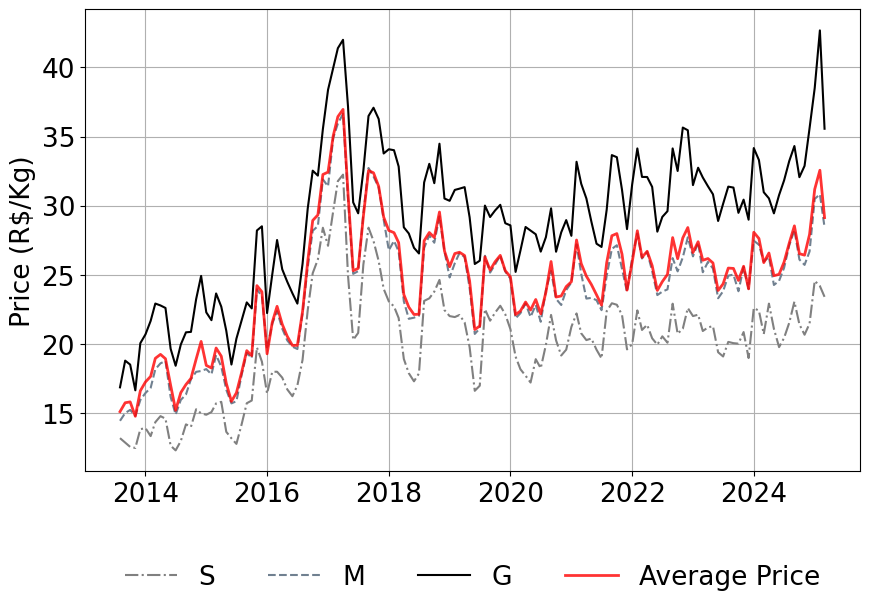

In [135]:
plt.figure(figsize=(10, 6))

for category in ["S", "M", "G"]:
    subset = df_monthly[df_monthly["Size_Quality_classification"] == category]
    plt.plot(subset["YearMonth"],
             subset["AveragePrice"],
             color=styles[category]["color"],
             linestyle=styles[category]["linestyle"],
             label=styles[category]["label"])

plt.plot(dfsp_monthly_avg["YearMonth"],
         dfsp_monthly_avg["AveragePrice"],
         color="red",
         linestyle="solid",
         linewidth=2,
         alpha=0.8,
         label="Average Price")

plt.ylabel("Price (R$/Kg)")
plt.grid(True)
plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.15), ncol=4, frameon=False)

#plt.savefig("shrimp_price_ceagesp_average.jpeg", dpi=400, bbox_inches='tight')
plt.show()

In [136]:
# Mudando nome das colunas para dar 'merge' posteriormente

dfsp_monthly_avg=dfsp_monthly_avg.rename(columns={"YearMonth":'Date',"AveragePrice":'Retail_SP'})

#### Preços exportação

In [137]:
dfn = df[df['Mesoregião']=='Northeast']
dfn

,Ano,Mês,UF do Produto,Via,Bloco Econômico,Código NCM,Descrição NCM,Países,Valor US$ FOB,Quilograma Líquido,Tons,Price/Kg,Date,Região Simplificada,Mesoregião
29,2025,01,Maranhão,MARITIMA,África,3061790,"Outros camarões, que não inteiros, congelados",Libéria,763,95,0.095,8.031579,2025/01,Others,Northeast
39,2025,01,Maranhão,MARITIMA,Ásia (Exclusive Oriente Médio),3061790,"Outros camarões, que não inteiros, congelados",Hong Kong,630,72,0.072,8.750000,2025/01,Asia,Northeast
46,2025,01,Bahia,MARITIMA,África,3061710,"Outros camarões inteiros, congelados",Libéria,529,40,0.040,13.225000,2025/01,Others,Northeast
49,2025,01,Alagoas,MARITIMA,Ásia (Exclusive Oriente Médio),3061790,"Outros camarões, que não inteiros, congelados",Hong Kong,483,28,0.028,17.250000,2025/01,Asia,Northeast
50,2025,02,Alagoas,MARITIMA,Ásia (Exclusive Oriente Médio),3061790,"Outros camarões, que não inteiros, congelados",Coreia do Sul,483,20,0.020,24.150000,2025/02,Asia,Northeast
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11315,1997,09,Ceará,MARITIMA,América do Norte,3061300,Camarões congelados,Estados Unidos,91280,10000,10.000,9.128000,1997/09,North America,Northeast
11316,1997,05,Ceará,MARITIMA,Europa,3061300,Camarões congelados,França,81790,8840,8.840,9.252262,1997/05,Europe,Northeast
11317,1997,03,Ceará,MARITIMA,Europa,3061300,Camarões congelados,Bélgica,73968,9000,9.000,8.218667,1997/03,Europe,Northeast
11321,1997,04,Bahia,MARITIMA,América do Norte,3061300,Camarões congelados,Estados Unidos,56222,4560,4.560,12.329386,1997/04,North America,Northeast


In [138]:
dfn['Descrição NCM'].value_counts()

,count
Descrição NCM,
"Camarões, inteiros, congelados, exceto ""krill""",1489
"Outros camarões, que não inteiros, congelados",930
"Outros camarões inteiros, congelados",774
"Outros camarões congelados, exceto ""krill""",774
Camarões congelados,555
Camarões,299


In [139]:
dfn["Descrição NCM"] = dfn["Descrição NCM"].replace({
    'Camarões, inteiros, congelados, exceto "krill"':
    'Frozen shrimps',
    "Outros camarões, que não inteiros, congelados":
    'Frozen shrimps',
    'Outros camarões inteiros, congelados':
    'Frozen shrimps',
    'Outros camarões congelados, exceto "krill"':
    'Frozen shrimps',
    'Camarões congelados':
    'Frozen shrimps',
    'Camarões':
    'Frozen shrimps'
})

dfn['Descrição NCM'].value_counts()

<ipython-input-139-4239467980>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn["Descrição NCM"] = dfn["Descrição NCM"].replace({


,count
Descrição NCM,
Frozen shrimps,4821


In [140]:
dfn_monthly_avg = dfn.groupby(
    "Date")["Price/Kg"].mean().reset_index()
dfn_monthly_avg["Date"] = dfn_monthly_avg["Date"].astype(str)
dfn_monthly_avg["Date"] = pd.to_datetime(dfn_monthly_avg["Date"])

<ipython-input-140-441685718>:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  dfn_monthly_avg["Date"] = pd.to_datetime(dfn_monthly_avg["Date"])


In [141]:
dfn_monthly_avg

,Date,Price/Kg
0,1997-03-01,8.218667
1,1997-04-01,11.126310
2,1997-05-01,8.158730
3,1997-06-01,9.381021
4,1997-07-01,8.920623
...,...,...
260,2024-10-01,12.396314
261,2024-11-01,12.660230
262,2024-12-01,10.949969
263,2025-01-01,9.774891


In [142]:
dfn_monthly_avg["Date"] = pd.to_datetime(dfn_monthly_avg["Date"])
dfn_monthly_avg = dfn_monthly_avg[dfn_monthly_avg["Date"] >= "2013-08-01"]
dfn_monthly_avg

,Date,Price/Kg
167,2013-08-01,6.123698
168,2013-09-01,7.449545
169,2013-10-01,6.889196
170,2013-11-01,6.363534
171,2013-12-01,6.615833
...,...,...
260,2024-10-01,12.396314
261,2024-11-01,12.660230
262,2024-12-01,10.949969
263,2025-01-01,9.774891


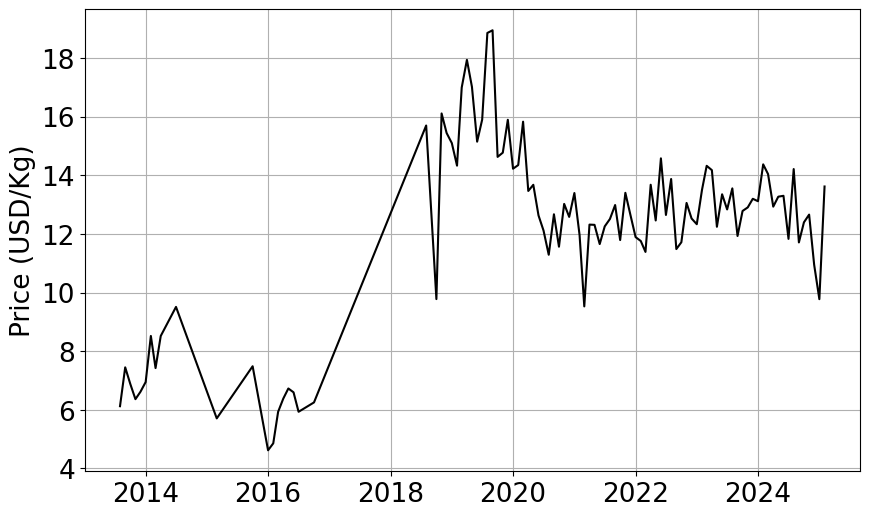

In [143]:
plt.figure(figsize=(10, 6))

plt.plot(dfn_monthly_avg["Date"],
         dfn_monthly_avg["Price/Kg"],
         color="black",
         linestyle="solid",
         label="Price (R$/Kg)")

plt.ylabel("Price (USD/Kg)")
plt.grid(True)

plt.show()

#### Camarões de pesca

In [144]:
dfno = df[df['Mesoregião']=='North']
dfno

,Ano,Mês,UF do Produto,Via,Bloco Econômico,Código NCM,Descrição NCM,Países,Valor US$ FOB,Quilograma Líquido,Tons,Price/Kg,Date,Região Simplificada,Mesoregião
0,2025,02,Pará,MARITIMA,Ásia (Exclusive Oriente Médio),3061790,"Outros camarões, que não inteiros, congelados",Japão,256538,16916,16.916,15.165406,2025/02,Asia,North
40,2025,01,Amazonas,MARITIMA,África,3061790,"Outros camarões, que não inteiros, congelados",Guiné-Bissau,615,30,0.030,20.500000,2025/01,Others,North
87,2025,01,Pará,MARITIMA,Ásia (Exclusive Oriente Médio),3061710,"Outros camarões inteiros, congelados",Hong Kong,274,20,0.020,13.700000,2025/01,Asia,North
126,2025,01,Pará,VIA NAO DECLARADA,América Central e Caribe,3061710,"Outros camarões inteiros, congelados",Panamá,171,30,0.030,5.700000,2025/01,Others,North
154,2025,02,Pará,MARITIMA,África,3061710,"Outros camarões inteiros, congelados",Libéria,124,10,0.010,12.400000,2025/02,Others,North
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11306,1997,04,Amapá,MARITIMA,Ásia (Exclusive Oriente Médio),3061300,Camarões congelados,Japão,200031,19836,19.836,10.084241,1997/04,Asia,North
11308,1997,08,Pará,MARITIMA,América do Norte,3061300,Camarões congelados,Estados Unidos,189219,21168,21.168,8.938917,1997/08,North America,North
11309,1997,07,Pará,MARITIMA,Europa,3061300,Camarões congelados,Bélgica,166334,15444,15.444,10.770137,1997/07,Europe,North
11310,1997,07,Pará,MARITIMA,Europa,3061300,Camarões congelados,França,115596,9360,9.360,12.350000,1997/07,Europe,North


In [145]:
dfno["Descrição NCM"] = dfno["Descrição NCM"].replace({
    'Camarões, inteiros, congelados, exceto "krill"':
    'Frozen shrimps',
    "Outros camarões, que não inteiros, congelados":
    'Frozen shrimps',
    'Outros camarões inteiros, congelados':
    'Frozen shrimps',
    'Outros camarões congelados, exceto "krill"':
    'Frozen shrimps',
    'Camarões congelados':
    'Frozen shrimps',
    'Camarões':
    'Frozen shrimps'
})

dfno['Descrição NCM'].value_counts()

<ipython-input-145-837475665>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfno["Descrição NCM"] = dfno["Descrição NCM"].replace({


,count
Descrição NCM,
Frozen shrimps,851


In [146]:
dfno_monthly_avg = dfno.groupby(
    "Date")["Price/Kg"].mean().reset_index()
dfno_monthly_avg["Date"] = dfno_monthly_avg["Date"].astype(str)
dfno_monthly_avg["Date"] = pd.to_datetime(dfno_monthly_avg["Date"])

<ipython-input-146-75033266>:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  dfno_monthly_avg["Date"] = pd.to_datetime(dfno_monthly_avg["Date"])


In [147]:
dfno_monthly_avg["Date"] = pd.to_datetime(dfno_monthly_avg["Date"])
dfno_monthly_avg = dfno_monthly_avg[dfno_monthly_avg["Date"] >= "2013-08-01"]
dfno_monthly_avg

,Date,Price/Kg
183,2013-08-01,15.459135
184,2013-09-01,13.430200
185,2013-10-01,14.597276
186,2013-11-01,16.985128
187,2013-12-01,15.828203
...,...,...
295,2024-10-01,13.302564
296,2024-11-01,11.404167
297,2024-12-01,10.016402
298,2025-01-01,13.300000


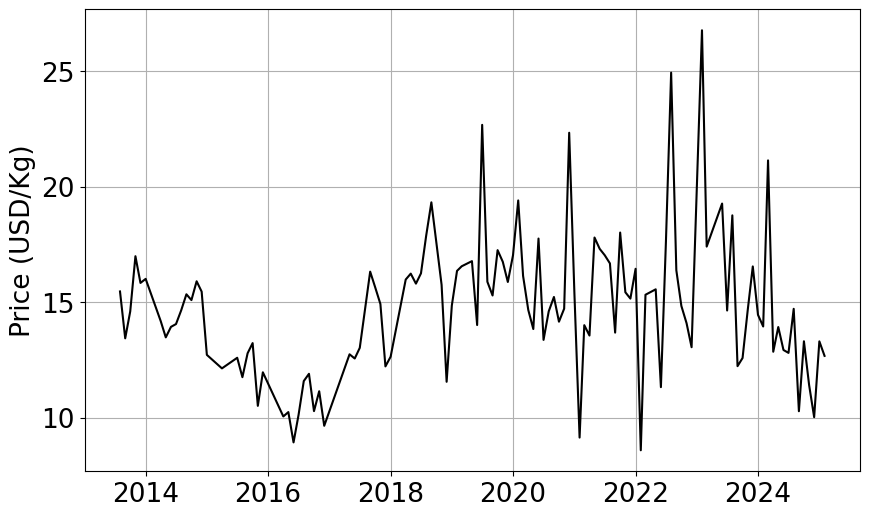

In [148]:
plt.figure(figsize=(10, 6))

plt.plot(dfno_monthly_avg["Date"],
         dfno_monthly_avg["Price/Kg"],
         color="black",
         linestyle="solid",
         label="Price (R$/Kg)")

plt.ylabel("Price (USD/Kg)")
plt.grid(True)

plt.show()

In [149]:
dfno_monthly_avg=dfno_monthly_avg.rename(columns={"Price/Kg":'Fished_prices'})
dfno_monthly_avg

,Date,Fished_prices
183,2013-08-01,15.459135
184,2013-09-01,13.430200
185,2013-10-01,14.597276
186,2013-11-01,16.985128
187,2013-12-01,15.828203
...,...,...
295,2024-10-01,13.302564
296,2024-11-01,11.404167
297,2024-12-01,10.016402
298,2025-01-01,13.300000


#### Merging data

In [150]:
dfn_monthly_avg=dfn_monthly_avg.rename(columns={"Price/Kg":'Aquaculture_Export_Dol'})
dfn_monthly_avg

,Date,Aquaculture_Export_Dol
167,2013-08-01,6.123698
168,2013-09-01,7.449545
169,2013-10-01,6.889196
170,2013-11-01,6.363534
171,2013-12-01,6.615833
...,...,...
260,2024-10-01,12.396314
261,2024-11-01,12.660230
262,2024-12-01,10.949969
263,2025-01-01,9.774891


In [151]:
dfn2 = dfn
dfn2['Date'] = pd.to_datetime(dfn2['Date'])
dfn2.set_index('Date', inplace=True)

start_date = dfn2.index.min().strftime('%Y-%m-%d')
end_date = dfn2.index.max().strftime('%Y-%m-%d')

<ipython-input-151-3535073531>:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  dfn2['Date'] = pd.to_datetime(dfn2['Date'])
<ipython-input-151-3535073531>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn2['Date'] = pd.to_datetime(dfn2['Date'])


In [152]:
ex_rate_data = yf.download('BRL=X', start=start_date, end=end_date, interval='1d')
monthly_ex_rate = ex_rate_data['Close'].resample('M').mean()

exchange_rates = monthly_ex_rate.reset_index()
exchange_rates.columns = ['Date', 'Exchange_Rate']

print(exchange_rates.head())

<ipython-input-152-739941420>:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  ex_rate_data = yf.download('BRL=X', start=start_date, end=end_date, interval='1d')
[*********************100%***********************]  1 of 1 completed

        Date  Exchange_Rate
0 2003-12-31       2.921348
1 2004-01-31       2.852091
2 2004-02-29       2.927350
3 2004-03-31       2.902696
4 2004-04-30       2.905182



<ipython-input-152-739941420>:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_ex_rate = ex_rate_data['Close'].resample('M').mean()


In [153]:
monthly_ex_rate = ex_rate_data['Close'].resample('M').mean()
exchange_rates = monthly_ex_rate.reset_index()
exchange_rates.columns = ['Date', 'Exchange_Rate']

<ipython-input-153-2476189982>:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_ex_rate = ex_rate_data['Close'].resample('M').mean()


In [154]:
exchange_rates

,Date,Exchange_Rate
0,2003-12-31,2.921348
1,2004-01-31,2.852091
2,2004-02-29,2.927350
3,2004-03-31,2.902696
4,2004-04-30,2.905182
...,...,...
249,2024-09-30,5.549722
250,2024-10-31,5.604753
251,2024-11-30,5.783444
252,2024-12-31,6.098623


In [155]:
exchange_rates = exchange_rates[exchange_rates["Date"] >= "2013-08-01"]
exchange_rates = exchange_rates.groupby(
    "Date")["Exchange_Rate"].mean().reset_index()
exchange_rates["Date"] = exchange_rates["Date"].astype(str)
exchange_rates["Date"] = pd.to_datetime(exchange_rates["Date"])

In [156]:
dfsp_monthly_avg["Date"] = pd.to_datetime(dfsp_monthly_avg["Date"]) + pd.offsets.MonthEnd(0)
exchange_rates["Date"] = pd.to_datetime(exchange_rates["Date"])

In [157]:
merged_df_brl = dfsp_monthly_avg.merge(exchange_rates, on="Date", how="left")
merged_df_brl["Aquaculture_whlsl_Dol"] = merged_df_brl["Retail_SP"]/merged_df_brl["Exchange_Rate"]
merged_df_brl=merged_df_brl.dropna()
merged_df_brl

,Date,Retail_SP,Exchange_Rate,Aquaculture_whlsl_Dol
0,2013-08-31,15.124074,2.337382,6.470519
1,2013-09-30,15.765873,2.269638,6.946426
2,2013-10-31,15.830189,2.185359,7.243747
3,2013-11-30,14.789062,2.290524,6.456629
4,2013-12-31,16.630952,2.343455,7.096768
...,...,...,...,...
133,2024-09-30,28.552870,5.549722,5.144919
134,2024-10-31,26.541453,5.604753,4.735526
135,2024-11-30,26.434444,5.783444,4.570710
136,2024-12-31,27.934778,6.098623,4.580506


In [158]:
merged_df_brl=merged_df_brl.rename(columns={"Retail_SP":'Aquaculture_whlsl_BRL'})
merged_df_brl

,Date,Aquaculture_whlsl_BRL,Exchange_Rate,Aquaculture_whlsl_Dol
0,2013-08-31,15.124074,2.337382,6.470519
1,2013-09-30,15.765873,2.269638,6.946426
2,2013-10-31,15.830189,2.185359,7.243747
3,2013-11-30,14.789062,2.290524,6.456629
4,2013-12-31,16.630952,2.343455,7.096768
...,...,...,...,...
133,2024-09-30,28.552870,5.549722,5.144919
134,2024-10-31,26.541453,5.604753,4.735526
135,2024-11-30,26.434444,5.783444,4.570710
136,2024-12-31,27.934778,6.098623,4.580506


In [159]:
merged_df_brl['Date'] = pd.to_datetime(merged_df_brl['Date'])
dfn_monthly_avg['Date'] = pd.to_datetime(dfn_monthly_avg['Date'])

# Criar coluna auxiliar com ano e mês
merged_df_brl['YearMonth'] = merged_df_brl['Date'].dt.to_period('M')
dfn_monthly_avg['YearMonth'] = dfn_monthly_avg['Date'].dt.to_period('M')

# Realizar o left join usando a coluna auxiliar
merged_df2 = pd.merge(merged_df_brl, dfn_monthly_avg, how='left', on='YearMonth')

In [160]:
merged_df2

,Date_x,Aquaculture_whlsl_BRL,Exchange_Rate,Aquaculture_whlsl_Dol,YearMonth,Date_y,Aquaculture_Export_Dol
0,2013-08-31,15.124074,2.337382,6.470519,2013-08,2013-08-01,6.123698
1,2013-09-30,15.765873,2.269638,6.946426,2013-09,2013-09-01,7.449545
2,2013-10-31,15.830189,2.185359,7.243747,2013-10,2013-10-01,6.889196
3,2013-11-30,14.789062,2.290524,6.456629,2013-11,2013-11-01,6.363534
4,2013-12-31,16.630952,2.343455,7.096768,2013-12,2013-12-01,6.615833
...,...,...,...,...,...,...,...
133,2024-09-30,28.552870,5.549722,5.144919,2024-09,2024-09-01,11.711510
134,2024-10-31,26.541453,5.604753,4.735526,2024-10,2024-10-01,12.396314
135,2024-11-30,26.434444,5.783444,4.570710,2024-11,2024-11-01,12.660230
136,2024-12-31,27.934778,6.098623,4.580506,2024-12,2024-12-01,10.949969


In [161]:
merged_df2 = merged_df2[['YearMonth', 'Aquaculture_Export_Dol', 'Aquaculture_whlsl_BRL', 'Aquaculture_whlsl_Dol','Exchange_Rate']]
merged_df2

,YearMonth,Aquaculture_Export_Dol,Aquaculture_whlsl_BRL,Aquaculture_whlsl_Dol,Exchange_Rate
0,2013-08,6.123698,15.124074,6.470519,2.337382
1,2013-09,7.449545,15.765873,6.946426,2.269638
2,2013-10,6.889196,15.830189,7.243747,2.185359
3,2013-11,6.363534,14.789062,6.456629,2.290524
4,2013-12,6.615833,16.630952,7.096768,2.343455
...,...,...,...,...,...
133,2024-09,11.711510,28.552870,5.144919,5.549722
134,2024-10,12.396314,26.541453,4.735526,5.604753
135,2024-11,12.660230,26.434444,4.570710,5.783444
136,2024-12,10.949969,27.934778,4.580506,6.098623


In [162]:
dfno_monthly_avg['Date'] = pd.to_datetime(dfno_monthly_avg['Date'])
dfno_monthly_avg['YearMonth'] = dfno_monthly_avg['Date'].dt.to_period('M')

merged_df3 = pd.merge(merged_df2, dfno_monthly_avg, how='left', on='YearMonth')

merged_df3 = merged_df3[['YearMonth', 'Aquaculture_Export_Dol', 'Aquaculture_whlsl_BRL', 'Aquaculture_whlsl_Dol','Fished_prices','Exchange_Rate']]
merged_df3=merged_df3.rename(columns={"Fished_prices":'Capture_Export_Dol'})

merged_df3['Capture_Export_Dol']=merged_df3['Capture_Export_Dol'].interpolate(method="linear")
merged_df3

,YearMonth,Aquaculture_Export_Dol,Aquaculture_whlsl_BRL,Aquaculture_whlsl_Dol,Capture_Export_Dol,Exchange_Rate
0,2013-08,6.123698,15.124074,6.470519,15.459135,2.337382
1,2013-09,7.449545,15.765873,6.946426,13.430200,2.269638
2,2013-10,6.889196,15.830189,7.243747,14.597276,2.185359
3,2013-11,6.363534,14.789062,6.456629,16.985128,2.290524
4,2013-12,6.615833,16.630952,7.096768,15.828203,2.343455
...,...,...,...,...,...,...
133,2024-09,11.711510,28.552870,5.144919,10.273636,5.549722
134,2024-10,12.396314,26.541453,4.735526,13.302564,5.604753
135,2024-11,12.660230,26.434444,4.570710,11.404167,5.783444
136,2024-12,10.949969,27.934778,4.580506,10.016402,6.098623


In [163]:
#merged_df3['Aquaculture_ExportPrices_Dol']=merged_df3['Aquaculture_ExportPrices_Dol'].interpolate(method="linear")
merged_df3['Aquaculture_Export_BRL'] = merged_df3[
    'Aquaculture_Export_Dol'] * merged_df3['Exchange_Rate']

merged_df3['Capture_Export_BRL'] = merged_df3[
    'Capture_Export_Dol'] * merged_df3['Exchange_Rate']

merged_df3 = merged_df3[[
    'YearMonth', 'Aquaculture_Export_Dol', 'Aquaculture_Export_BRL',
    'Aquaculture_whlsl_Dol', 'Aquaculture_whlsl_BRL', 'Capture_Export_Dol',
    'Capture_Export_BRL', 'Exchange_Rate'
]]

In [164]:
merged_df3

,YearMonth,Aquaculture_Export_Dol,Aquaculture_Export_BRL,Aquaculture_whlsl_Dol,Aquaculture_whlsl_BRL,Capture_Export_Dol,Capture_Export_BRL,Exchange_Rate
0,2013-08,6.123698,14.313421,6.470519,15.124074,15.459135,36.133900,2.337382
1,2013-09,7.449545,16.907770,6.946426,15.765873,13.430200,30.481694,2.269638
2,2013-10,6.889196,15.055368,7.243747,15.830189,14.597276,31.900289,2.185359
3,2013-11,6.363534,14.575826,6.456629,14.789062,16.985128,38.904840,2.290524
4,2013-12,6.615833,15.503905,7.096768,16.630952,15.828203,37.092674,2.343455
...,...,...,...,...,...,...,...,...
133,2024-09,11.711510,64.995632,5.144919,28.552870,10.273636,57.015830,5.549722
134,2024-10,12.396314,69.478272,4.735526,26.541453,13.302564,74.557582,5.604753
135,2024-11,12.660230,73.219733,4.570710,26.434444,11.404167,65.955360,5.783444
136,2024-12,10.949969,66.779729,4.580506,27.934778,10.016402,61.086256,6.098623


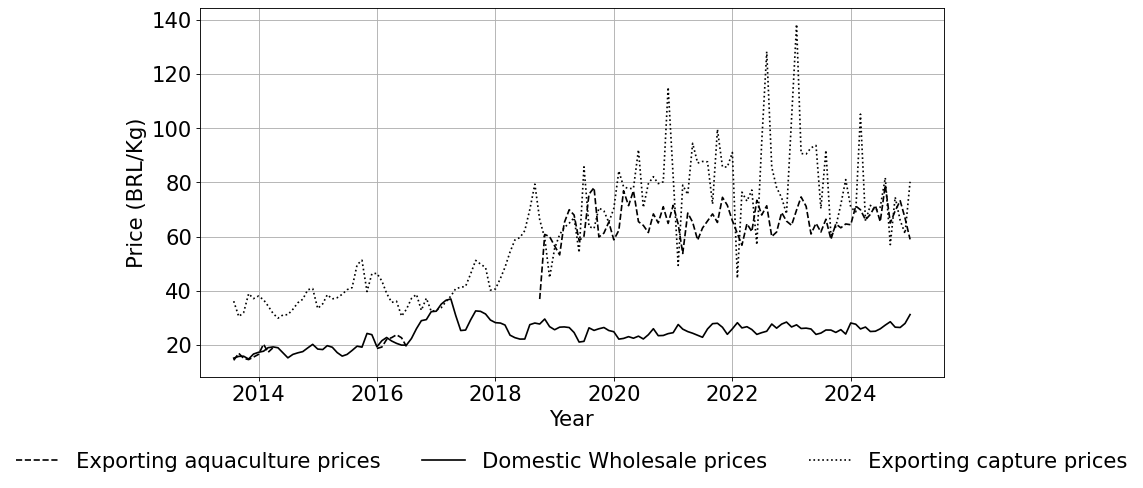

In [165]:
merged_df3['YearMonth'] = merged_df3['YearMonth'].dt.to_timestamp()
merged_df3.set_index('YearMonth', inplace=True)

fig, axes = plt.subplots(1, 1, figsize=(12, 6), dpi=80)
plt.xlabel("Year", fontsize=19)
plt.ylabel("Price (BRL/Kg)", fontsize=19)
plt.plot(merged_df3['Aquaculture_Export_BRL'], color="black", linestyle = 'dashed', label='Exporting aquaculture prices')
plt.plot(merged_df3['Aquaculture_whlsl_BRL'], color="black", linestyle = 'solid', label='Domestic Wholesale prices')
plt.plot(merged_df3['Capture_Export_BRL'], color = 'black', linestyle = 'dotted', label = 'Exporting capture prices')
plt.grid(True)
plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.15), ncol=4, frameon=False)
#plt.savefig("shrimp_price_Export_Wholesale_Capture_BRL25.jpeg", dpi=400, bbox_inches='tight')
plt.show()

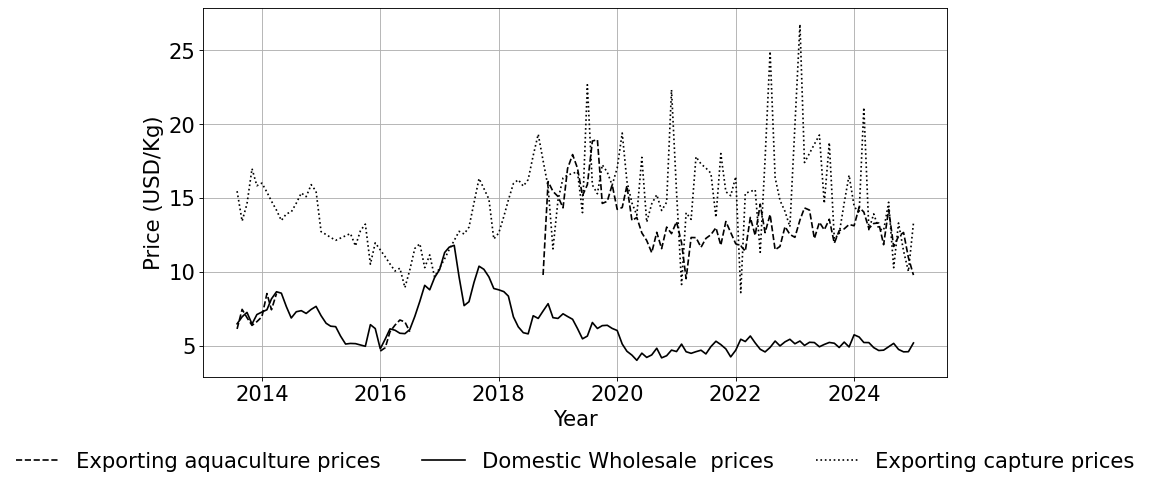

In [166]:
fig, axes = plt.subplots(1, 1, figsize=(12, 6), dpi=80)
plt.xlabel("Year", fontsize=19)
plt.ylabel("Price (USD/Kg)", fontsize=19)
plt.plot(merged_df3['Aquaculture_Export_Dol'], color="black", linestyle = 'dashed', label='Exporting aquaculture prices')
plt.plot(merged_df3['Aquaculture_whlsl_Dol'], color="black", linestyle = 'solid', label='Domestic Wholesale  prices')
plt.plot(merged_df3['Capture_Export_Dol'], color = 'black', linestyle = 'dotted', label = 'Exporting capture prices')
plt.grid(True)
plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.15), ncol=4, frameon=False)
#plt.savefig("shrimp_price_Export_Wholesale_Capture_USD.jpeg", dpi=400, bbox_inches='tight')
plt.show()

### Farmgate prices

In [167]:
fgp = pd.read_excel('Farmgate_prices.xlsx', sheet_name='Planilha1')
fgp

,UF,Ano-Mês-Hora,Preço
0,RN,2020-05-16 00:00:00,12.0
1,RN,2020-06-28 00:00:00,14.0
2,AL,2020-07-26 00:00:00,16.0
3,RN,2020-07-29 00:00:00,16.0
4,RN,2020-07-31 00:00:00,16.0
...,...,...,...
1537,NaN,2024-12- 02,NaN
1538,NaN,2024-12-09,NaN
1539,NaN,2024-12-16,NaN
1540,NaN,2024-12-23,NaN


In [168]:
fgp['Ano-Mês-Hora'] = pd.to_datetime(fgp['Ano-Mês-Hora'], errors='coerce')
fgp = fgp.dropna(subset=['Ano-Mês-Hora'])

In [169]:
fgp['Year-Month'] = fgp['Ano-Mês-Hora'].dt.to_period('M')
monthly_mean = fgp.groupby('Year-Month')['Preço'].mean().to_frame()

<ipython-input-169-3694190620>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fgp['Year-Month'] = fgp['Ano-Mês-Hora'].dt.to_period('M')


In [170]:
monthly_mean.index = monthly_mean.index.to_timestamp()

In [171]:
full_range = pd.date_range(start=monthly_mean.index.min(), end='2024-12', freq='MS')
monthly_mean = monthly_mean.reindex(full_range)

In [172]:
monthly_mean = monthly_mean.reset_index().rename(columns={'index': 'Year-Month'})
monthly_mean['Preço']=monthly_mean['Preço'].interpolate(method="linear")
monthly_mean=monthly_mean.rename(columns={"Preço":'Farmgate_BRL'})
monthly_mean

,Year-Month,Farmgate_BRL
0,2020-05-01,12.000000
1,2020-06-01,14.000000
2,2020-07-01,16.000000
3,2020-08-01,17.500000
4,2020-09-01,19.000000
5,2020-10-01,19.750000
6,2020-11-01,17.333333
7,2020-12-01,18.500000
8,2021-01-01,19.494186
9,2021-02-01,18.770833


In [173]:
last_four = monthly_mean.tail(4)
avg_jan_2025 = last_four['Farmgate_BRL'].mean()

# Create new row for January 2025
new_row = pd.DataFrame({
    'Year-Month': [pd.Timestamp('2025-01-01')],
    'Farmgate_BRL': [avg_jan_2025]
})

# Append to monthly_mean
monthly_mean = pd.concat([monthly_mean, new_row], ignore_index=True)

In [174]:
new_rows = []

# Create a copy to simulate extension
df_extended = monthly_mean.copy()

# Loop backward to estimate and prepend 4 new months
for i in range(4):
    earliest_date = df_extended['Year-Month'].min()
    new_date = (earliest_date - pd.DateOffset(months=1)).replace(day=1)
    avg_price = df_extended['Farmgate_BRL'].iloc[:4].mean()
    new_rows.append({'Year-Month': new_date, 'Farmgate_BRL': avg_price})
    df_extended = pd.concat([pd.DataFrame([new_rows[-1]]), df_extended], ignore_index=True)

monthly_mean = pd.concat([pd.DataFrame(new_rows[::-1]), monthly_mean], ignore_index=True)
monthly_mean = monthly_mean.sort_values('Year-Month').reset_index(drop=True)
monthly_mean['Farmgate_BRL'] = monthly_mean['Farmgate_BRL'].round(2)

print(monthly_mean.head(10))

  Year-Month  Farmgate_BRL
0 2020-01-01         13.72
1 2020-02-01         13.77
2 2020-03-01         14.22
3 2020-04-01         14.88
4 2020-05-01         12.00
5 2020-06-01         14.00
6 2020-07-01         16.00
7 2020-08-01         17.50
8 2020-09-01         19.00
9 2020-10-01         19.75


In [175]:
monthly_mean['YearMonth'] = monthly_mean['Year-Month'].dt.to_period('M').dt.to_timestamp()


merged_df4 = pd.merge(merged_df3, monthly_mean[['YearMonth', 'Farmgate_BRL']], how='left', on='YearMonth')
merged_df4['Farmgate_Dol']=merged_df4['Farmgate_BRL']/merged_df4['Exchange_Rate']
merged_df4 = merged_df4[[
    'YearMonth', 'Aquaculture_Export_Dol', 'Aquaculture_Export_BRL',
    'Aquaculture_whlsl_Dol', 'Aquaculture_whlsl_BRL', 'Capture_Export_Dol',
    'Capture_Export_BRL', 'Farmgate_BRL','Farmgate_Dol','Exchange_Rate'
]]

merged_df4

,YearMonth,Aquaculture_Export_Dol,Aquaculture_Export_BRL,Aquaculture_whlsl_Dol,Aquaculture_whlsl_BRL,Capture_Export_Dol,Capture_Export_BRL,Farmgate_BRL,Farmgate_Dol,Exchange_Rate
0,2013-08-01,6.123698,14.313421,6.470519,15.124074,15.459135,36.133900,NaN,NaN,2.337382
1,2013-09-01,7.449545,16.907770,6.946426,15.765873,13.430200,30.481694,NaN,NaN,2.269638
2,2013-10-01,6.889196,15.055368,7.243747,15.830189,14.597276,31.900289,NaN,NaN,2.185359
3,2013-11-01,6.363534,14.575826,6.456629,14.789062,16.985128,38.904840,NaN,NaN,2.290524
4,2013-12-01,6.615833,15.503905,7.096768,16.630952,15.828203,37.092674,NaN,NaN,2.343455
...,...,...,...,...,...,...,...,...,...,...
133,2024-09-01,11.711510,64.995632,5.144919,28.552870,10.273636,57.015830,18.35,3.306472,5.549722
134,2024-10-01,12.396314,69.478272,4.735526,26.541453,13.302564,74.557582,18.35,3.274007,5.604753
135,2024-11-01,12.660230,73.219733,4.570710,26.434444,11.404167,65.955360,18.35,3.172850,5.783444
136,2024-12-01,10.949969,66.779729,4.580506,27.934778,10.016402,61.086256,18.35,3.008876,6.098623


In [176]:
merged_df4_2 = merged_df4[[
    'YearMonth', 'Aquaculture_Export_Dol',
    'Aquaculture_whlsl_Dol', 'Capture_Export_Dol',
    'Exchange_Rate'
]]
#merged_df4_2.to_excel('precos_camaroes_completo.xlsx', index=False)
merged_df4_2

,YearMonth,Aquaculture_Export_Dol,Aquaculture_whlsl_Dol,Capture_Export_Dol,Exchange_Rate
0,2013-08-01,6.123698,6.470519,15.459135,2.337382
1,2013-09-01,7.449545,6.946426,13.430200,2.269638
2,2013-10-01,6.889196,7.243747,14.597276,2.185359
3,2013-11-01,6.363534,6.456629,16.985128,2.290524
4,2013-12-01,6.615833,7.096768,15.828203,2.343455
...,...,...,...,...,...
133,2024-09-01,11.711510,5.144919,10.273636,5.549722
134,2024-10-01,12.396314,4.735526,13.302564,5.604753
135,2024-11-01,12.660230,4.570710,11.404167,5.783444
136,2024-12-01,10.949969,4.580506,10.016402,6.098623


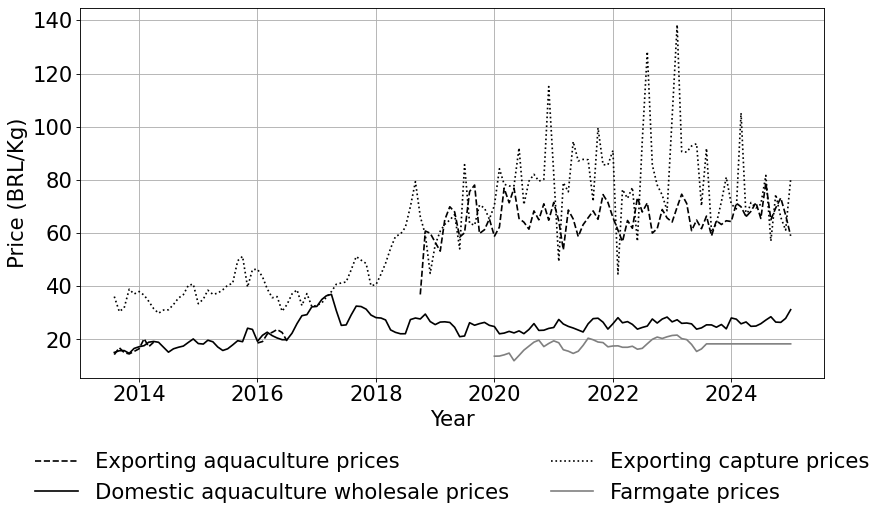

In [177]:
merged_df4.set_index('YearMonth', inplace=True)

fig, axes = plt.subplots(1, 1, figsize=(12, 6), dpi=80)
plt.xlabel("Year", fontsize=19)
plt.ylabel("Price (BRL/Kg)", fontsize=19)
plt.plot(merged_df4['Aquaculture_Export_BRL'], color="black", linestyle = 'dashed', label='Exporting aquaculture prices')
plt.plot(merged_df4['Aquaculture_whlsl_BRL'], color="black", linestyle = 'solid', label='Domestic aquaculture wholesale prices')
plt.plot(merged_df4['Capture_Export_BRL'], color = 'black', linestyle = 'dotted', label = 'Exporting capture prices')
plt.plot(merged_df4['Farmgate_BRL'], color = 'gray', linestyle = 'solid', label = 'Farmgate prices')
plt.grid(True)
plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.15), ncol=2, frameon=False)
plt.savefig("shrimp_price_Export_Wholesale_Capture_BRL25.jpeg", dpi=400, bbox_inches='tight')
plt.show()

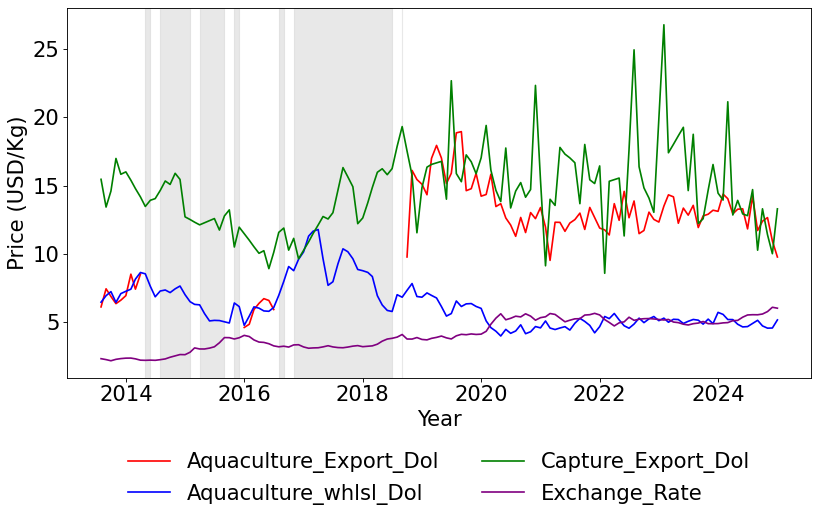

In [178]:
fig, axes = plt.subplots(1, 1, figsize=(12, 6), dpi=80)
plt.xlabel("Year", fontsize=19)
plt.ylabel("Price (USD/Kg)", fontsize=19)
plt.plot(merged_df4['Aquaculture_Export_Dol'], color="red", linestyle = 'solid', label='Aquaculture_Export_Dol')
plt.plot(merged_df4['Aquaculture_whlsl_Dol'], color="blue", linestyle = 'solid', label='Aquaculture_whlsl_Dol')
plt.plot(merged_df4['Capture_Export_Dol'], color = 'green', linestyle = 'solid', label = 'Capture_Export_Dol')
plt.plot(merged_df4['Exchange_Rate'], color = 'purple', linestyle = 'solid', label = 'Exchange_Rate')

is_nan = merged_df4['Aquaculture_Export_Dol'].isna()
nan_groups = (is_nan != is_nan.shift()).cumsum()  # Groups of consecutive values
for _, group in merged_df4[is_nan].groupby(nan_groups):
    start = group.index[0]
    end = group.index[-1]
    axes.axvspan(start, end, color='lightgrey', alpha=0.5)

plt.grid(False)
plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.15), ncol=2, frameon=False)
plt.savefig("shrimp_price_Export_Wholesale_Capture_USD25.png", dpi=500, bbox_inches='tight')
plt.show()

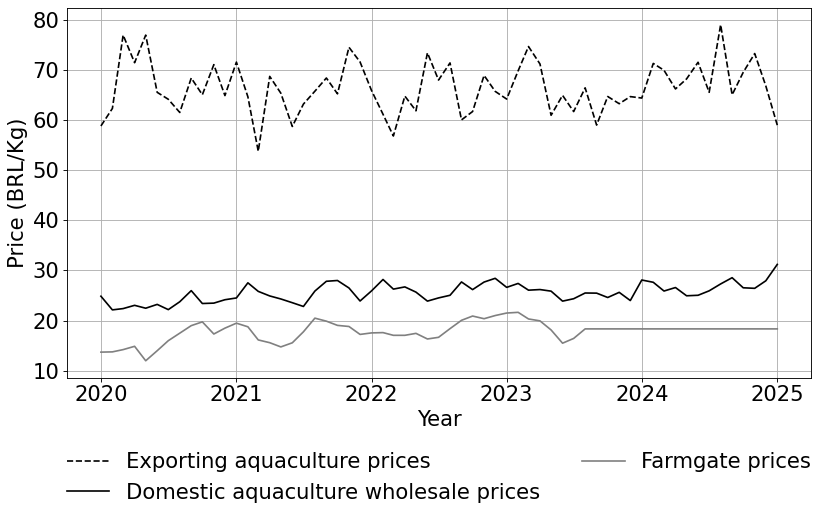

In [179]:
filtered_df = merged_df4.loc[merged_df4.index >= "2020-01-01"]

fig, axes = plt.subplots(1, 1, figsize=(12, 6), dpi=80)
plt.xlabel("Year", fontsize=19)
plt.ylabel("Price (BRL/Kg)", fontsize=19)
plt.plot(filtered_df['Aquaculture_Export_BRL'], color="black", linestyle = 'dashed', label='Exporting aquaculture prices')
plt.plot(filtered_df['Aquaculture_whlsl_BRL'], color="black", linestyle = 'solid', label='Domestic aquaculture wholesale prices')
#plt.plot(filtered_df['Capture_Export_BRL'], color = 'black', linestyle = 'dotted', label = 'Exporting capture prices')
plt.plot(filtered_df['Farmgate_BRL'], color = 'gray', linestyle = 'solid', label = 'Farmgate prices')
plt.grid(True)
plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.15), ncol=2, frameon=False)
plt.savefig("shrimp_price_Export_Wholesale_Capture_BRL25.jpeg", dpi=400, bbox_inches='tight')
plt.show()

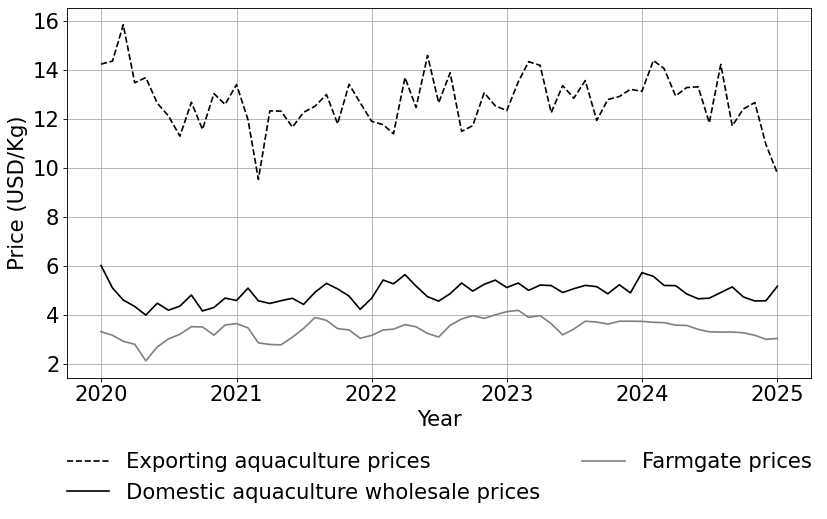

In [180]:
fig, axes = plt.subplots(1, 1, figsize=(12, 6), dpi=80)
plt.xlabel("Year", fontsize=19)
plt.ylabel("Price (USD/Kg)", fontsize=19)
plt.plot(filtered_df['Aquaculture_Export_Dol'], color="black", linestyle = 'dashed', label='Exporting aquaculture prices')
plt.plot(filtered_df['Aquaculture_whlsl_Dol'], color="black", linestyle = 'solid', label='Domestic aquaculture wholesale prices')
#plt.plot(filtered_df['Capture_Export_Dol'], color = 'black', linestyle = 'dotted', label = 'Exporting capture prices')
plt.plot(filtered_df['Farmgate_Dol'], color = 'gray', linestyle = 'solid', label = 'Farmgate prices')
plt.grid(True)
plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.15), ncol=2, frameon=False)
plt.savefig("shrimp_price_Export_Wholesale_Capture_BRL25.jpeg", dpi=400, bbox_inches='tight')
plt.show()

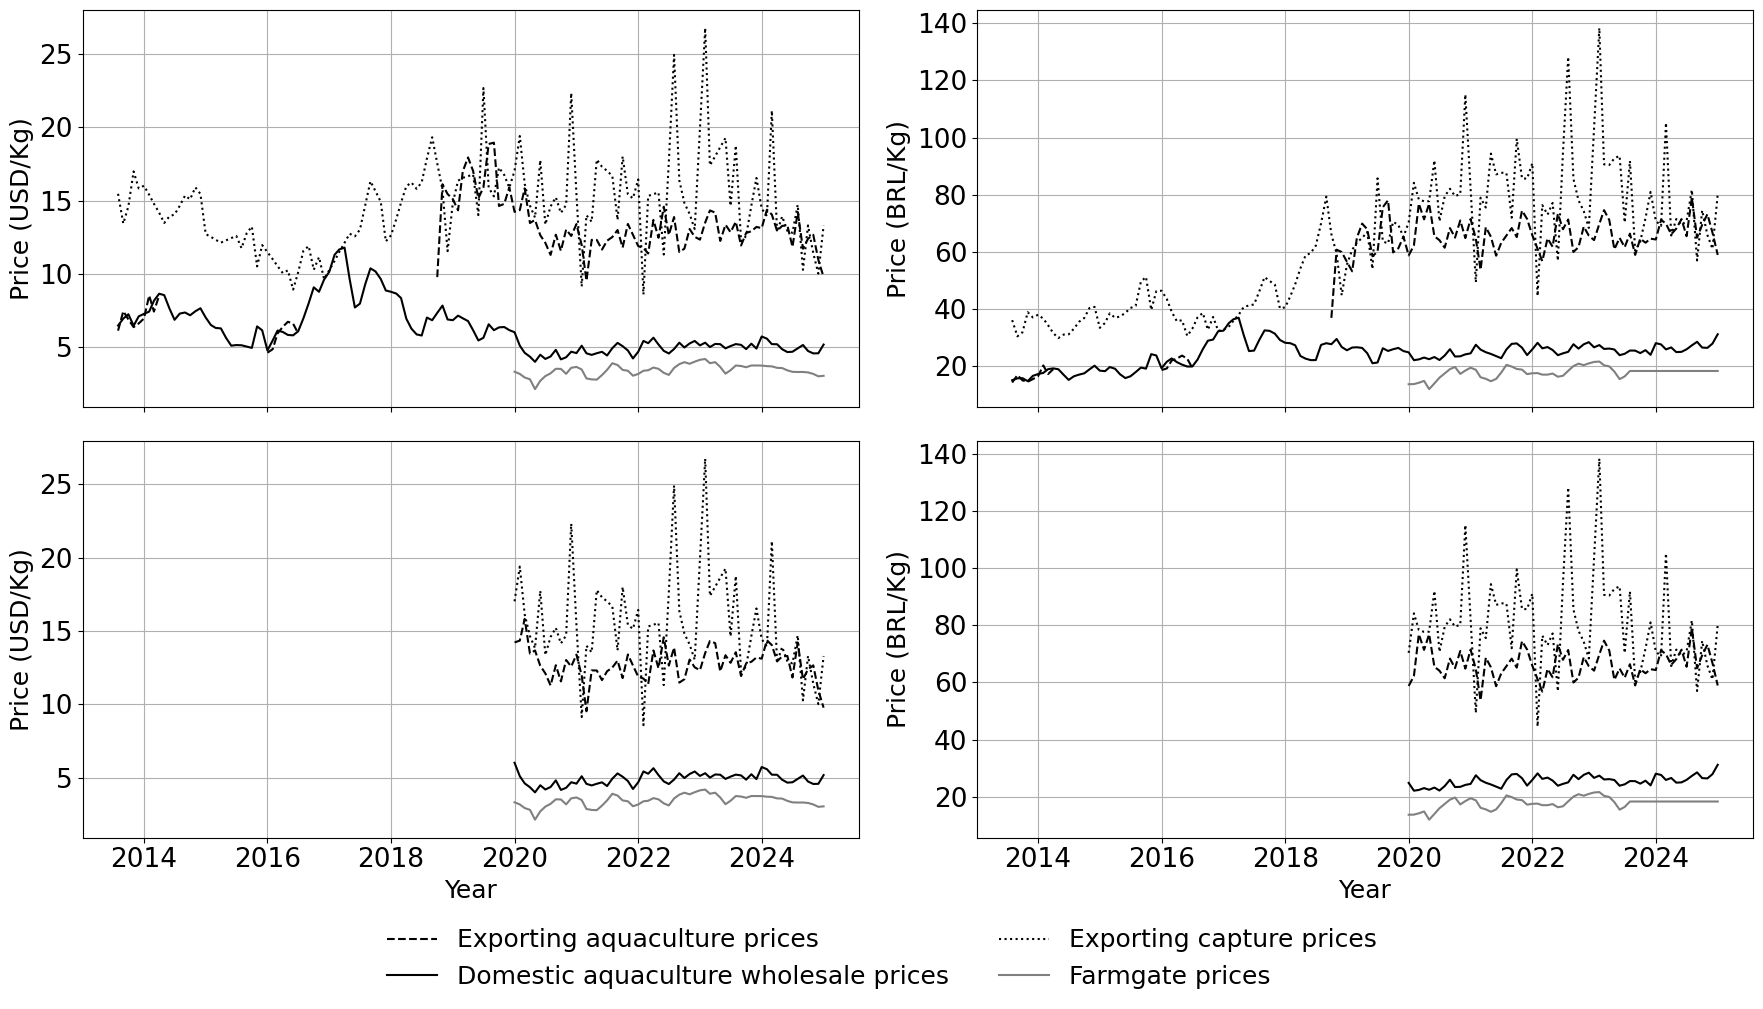

In [181]:
fig, axes = plt.subplots(2, 2, figsize=(18, 10), dpi=100, sharex=True)

# --- merged_df4 - USD ---
axes[0, 0].plot(merged_df4['Aquaculture_Export_Dol'], color="black", linestyle='dashed', label='Exporting aquaculture prices')
axes[0, 0].plot(merged_df4['Aquaculture_whlsl_Dol'], color="black", linestyle='solid', label='Domestic aquaculture wholesale prices')
axes[0, 0].plot(merged_df4['Capture_Export_Dol'], color="black", linestyle='dotted', label='Exporting capture prices')
axes[0, 0].plot(merged_df4['Farmgate_Dol'], color='gray', linestyle='solid', label='Farmgate prices')
axes[0, 0].set_ylabel("Price (USD/Kg)", fontsize=18)
axes[0, 0].grid(True)

# --- merged_df4 - BRL ---
axes[0, 1].plot(merged_df4['Aquaculture_Export_BRL'], color="black", linestyle='dashed', label='Exporting aquaculture prices')
axes[0, 1].plot(merged_df4['Aquaculture_whlsl_BRL'], color="black", linestyle='solid', label='Domestic aquaculture wholesale prices')
axes[0, 1].plot(merged_df4['Capture_Export_BRL'], color="black", linestyle='dotted', label='Exporting capture prices')
axes[0, 1].plot(merged_df4['Farmgate_BRL'], color='gray', linestyle='solid', label='Farmgate prices')
axes[0, 1].set_ylabel("Price (BRL/Kg)", fontsize=18)
axes[0, 1].grid(True)

# --- filtered_df - USD ---
axes[1, 0].plot(filtered_df['Aquaculture_Export_Dol'], color="black", linestyle='dashed', label='Exporting aquaculture prices')
axes[1, 0].plot(filtered_df['Aquaculture_whlsl_Dol'], color="black", linestyle='solid', label='Domestic aquaculture wholesale prices')
axes[1, 0].plot(filtered_df['Capture_Export_Dol'], color="black", linestyle='dotted', label='Exporting capture prices')
axes[1, 0].plot(filtered_df['Farmgate_Dol'], color='gray', linestyle='solid', label='Farmgate prices')
axes[1, 0].set_ylabel("Price (USD/Kg)", fontsize=18)
axes[1, 0].grid(True)

# --- filtered_df - BRL ---
axes[1, 1].plot(filtered_df['Aquaculture_Export_BRL'], color="black", linestyle='dashed', label='Exporting aquaculture prices')
axes[1, 1].plot(filtered_df['Aquaculture_whlsl_BRL'], color="black", linestyle='solid', label='Domestic aquaculture wholesale prices')
axes[1, 1].plot(filtered_df['Capture_Export_BRL'], color="black", linestyle='dotted', label='Exporting capture prices')
axes[1, 1].plot(filtered_df['Farmgate_BRL'], color='gray', linestyle='solid', label='Farmgate prices')
axes[1, 1].set_ylabel("Price (BRL/Kg)", fontsize=18)
axes[1, 1].grid(True)

# X-axis label for the entire figure
for ax in axes[1]:
    ax.set_xlabel("Year", fontsize=18)

lines_labels = axes[0, 0].get_legend_handles_labels()
fig.legend(*lines_labels, loc="lower center", bbox_to_anchor=(0.5, -0.03), ncol=2, frameon=False, fontsize=18)

plt.tight_layout(rect=[0, 0.05, 1, 1])  # leave space at bottom for legend
#plt.savefig("shrimp_price_panels_2x2_one_legend.png", dpi=400, bbox_inches="tight")
plt.show()

In [182]:
filtered_df = filtered_df.reset_index()
filtered_df = filtered_df[[
    'YearMonth', 'Aquaculture_Export_Dol', 'Aquaculture_whlsl_Dol','Capture_Export_Dol',
    'Farmgate_Dol','Exchange_Rate'
]]
filtered_df

,YearMonth,Aquaculture_Export_Dol,Aquaculture_whlsl_Dol,Capture_Export_Dol,Farmgate_Dol,Exchange_Rate
0,2020-01-01,14.226190,6.016904,17.030000,3.320220,4.132256
1,2020-02-01,14.349916,5.101007,19.400000,3.172834,4.339969
2,2020-03-01,15.830493,4.610397,16.133333,2.927194,4.857895
3,2020-04-01,13.466956,4.347008,14.656944,2.806676,5.301645
4,2020-05-01,13.677175,3.996642,13.833333,2.134417,5.622144
...,...,...,...,...,...,...
56,2024-09-01,11.711510,5.144919,10.273636,3.306472,5.549722
57,2024-10-01,12.396314,4.735526,13.302564,3.274007,5.604753
58,2024-11-01,12.660230,4.570710,11.404167,3.172850,5.783444
59,2024-12-01,10.949969,4.580506,10.016402,3.008876,6.098623


In [183]:
#filtered_df.to_excel('Brazil_Shrimp_Prices.xlsx', index=False)

In [184]:
filtered_df = pd.read_excel('Brazil_Shrimp_Prices.xlsx')
filtered_df

,YearMonth,Aquaculture_Export_Dol,Aquaculture_whlsl_Dol,Capture_Export_Dol,Farmgate_Dol,Exchange_Rate
0,2020-01-01,14.226190,6.016904,17.030000,3.320220,4.132256
1,2020-02-01,14.349916,5.101007,19.400000,3.172834,4.339969
2,2020-03-01,15.830493,4.610397,16.133333,2.927194,4.857895
3,2020-04-01,13.466956,4.347008,14.656944,2.806676,5.301645
4,2020-05-01,13.677175,3.996642,13.833333,2.134417,5.622144
...,...,...,...,...,...,...
56,2024-09-01,11.711510,5.144919,10.273636,3.865058,5.549722
57,2024-10-01,12.396314,4.735526,13.302564,3.721841,5.604753
58,2024-11-01,12.660230,4.570710,11.404167,3.606847,5.783444
59,2024-12-01,10.949969,4.580506,10.016402,3.420444,6.098623


### Para artigo de reconstrução

In [185]:
filtered_df['Year'] = pd.to_datetime(filtered_df['YearMonth']).dt.year
precos_medios = filtered_df.groupby('Year')[['Aquaculture_whlsl_Dol', 'Aquaculture_Export_Dol']].mean()

In [186]:
df_valores = pd.DataFrame({
    'Ano': ano,
    'Prod_kg': prod,  # já está em toneladas * 1000
    'Exp_kg': exp     # mesma unidade
})

In [187]:
df_valores = df_valores.merge(precos_medios, left_on='Ano', right_index=True, how='left')

In [188]:
df_valores['Receita_whlsl'] = df_valores['Prod_kg'] * df_valores['Aquaculture_whlsl_Dol']
df_valores['Receita_export'] = df_valores['Exp_kg'] * df_valores['Aquaculture_Export_Dol']

total_wholesale = df_valores['Receita_whlsl'].sum()
total_export = df_valores['Receita_export'].sum()

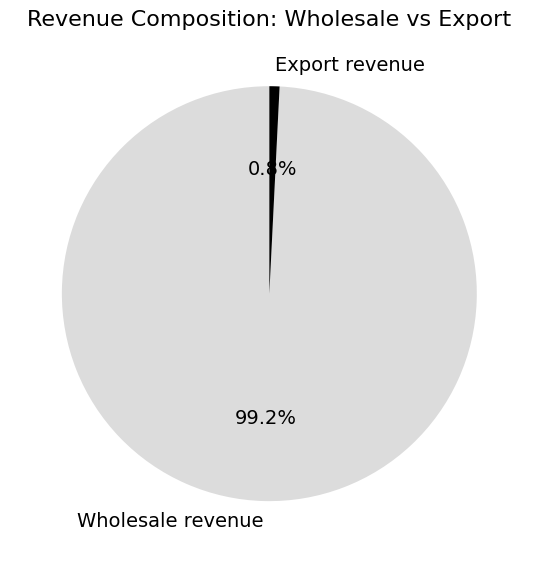

In [189]:
plt.figure(figsize=(6, 6))
valores = [total_wholesale, total_export]
labels = ['Wholesale revenue', 'Export revenue']
colors = ['gainsboro', 'black']

plt.pie(valores, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90, textprops={'fontsize': 14})
plt.title("Revenue Composition: Wholesale vs Export", fontsize=16)
plt.tight_layout()
# plt.savefig("shrimp_revenue_pie.jpeg", dpi=400)
plt.show()

In [190]:
label_map = {
    'Aquaculture_Export_Dol': 'exports',
    'Aquaculture_whlsl_Dol': 'domestic wholesale'
}

df_melted = filtered_df.melt(
    value_vars=['Aquaculture_Export_Dol', 'Aquaculture_whlsl_Dol'],
    var_name='Price_Type',
    value_name='Dollar_Price'
)
df_melted['Price_Type'] = df_melted['Price_Type'].map(label_map)

df_melted

,Price_Type,Dollar_Price
0,exports,14.226190
1,exports,14.349916
2,exports,15.830493
3,exports,13.466956
4,exports,13.677175
...,...,...
117,domestic wholesale,5.144919
118,domestic wholesale,4.735526
119,domestic wholesale,4.570710
120,domestic wholesale,4.580506


<ipython-input-191-1907282165>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_melted, x='Price_Type', y='Dollar_Price', palette='pastel')


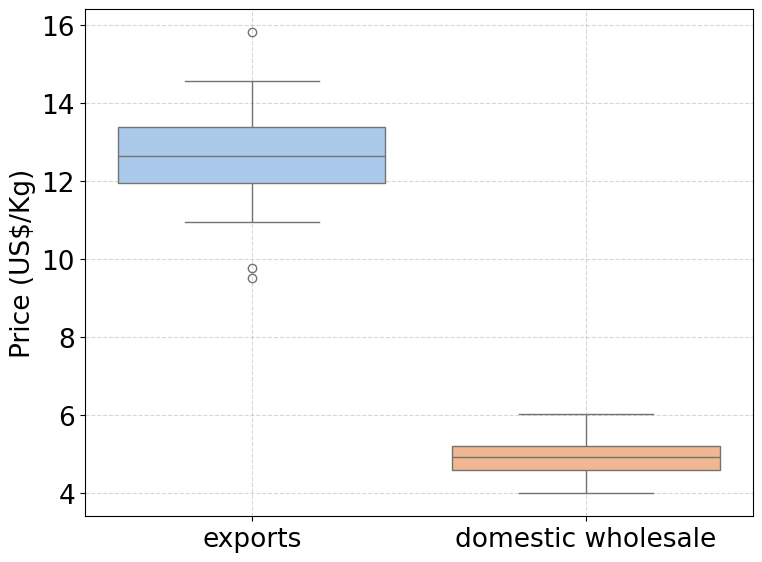

In [191]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=df_melted, x='Price_Type', y='Dollar_Price', palette='pastel')
plt.xlabel('')
plt.ylabel('Price (US$/Kg)')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
#plt.savefig("shrimp_prices_EXP_WHLS.jpg", dpi=400, bbox_inches="tight")
plt.show()